# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need? in thin the
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

### Download missing libraries
Comment in the following two lines in case some of the libraries cannot be imported. Please restart the kernel after download+upgrade has successfully finished.

**Please comment in these lines when the libraries cannot be imported below**

In [1]:
### Download libraries
#%pip install uproot 
#%pip install awkward 
#%pip install mplhep 
#%pip install numpy 
#%pip install matplotlib 
#%pip install scipy

### Upgrade libraries to latest version
#%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade

### Import libraries

In [2]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
import csv

## Important Functions

In [3]:
#final version
#Defining data path
path_data = '/Users/sayed/OneDrive/Dokumente/GitHub/z0-precisionmeasurement/'

#fit functions

def lin(x,a,b):
    return a*x+b
def f(x,a,b):
    return a*(1+x**2)+b/(1-x)**2
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
def breit_wigner(s,Mz,gamma_fe, gamma_z):
    s=s**2
    return 12*np.pi/Mz**2*(s*gamma_fe)/((s-Mz**2)**2+(s**2*gamma_z**2/Mz**2))
def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)
################################################################################
# testing functions


#the following function describes in which sigma interval of the literature values
# the measured or calculated values is 
# values between 0 and 3 indicate compatibility of the values whereby a value of 3 is borderline
def ttest(x, sx, y, sy = 0):
    return np.abs(x - y)/np.sqrt(sx**2 + sy**2)


def redchi2(data,fit,sigma,n_param=2):
    return np.sum((((data-fit)/sigma))**2) / (len(data)-n_param)

############################################################################

#reading data function

def CSV(file):
    rows = []
    with open(file, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            rows.append(row)
    mean_energy=np.array(list(zip(*rows[1:]))[0], dtype=float)#*increment+start
    lumi=np.array(list(zip(*rows[1:]))[1], dtype=float)
    stat=np.array(list(zip(*rows[1:]))[2], dtype=float)
    sys=np.array(list(zip(*rows[1:]))[3], dtype=float)
    alll=np.array(list(zip(*rows[1:]))[4], dtype=float)
    return mean_energy, lumi,stat, sys, alll

###################################################################
#particle counting functions

def count_particles(p,N,E,HE): #for Grope data
    num_had=0
    num_muon=0
    num_e=0
    num_tau=0
    for i in range(0,len(N)):
        if N[i]>=10 and E[i]<=60 and E[i]>=20 and HE[i]>=5 and p[i]<=100:
            num_had+=1
            #print('hadron')
        elif N[i]<=15 and p[i]<=100 and E[i]>=60 and HE[i]<=5:
            num_e+=1
            #print('electron')
        elif p[i]>=50 and p[i]>=50 and p[i]<=120 and N[i]<=10 and E[i]<=7 and HE[i]<=25:
            num_muon+=1
            #print('muon')
        elif N[i]<=15 and p[i]<=100 and E[i]>=10 and E[i]<=60 and HE[i]<=40:
            num_tau+=1
            #print('tau')
    return np.array([num_had, num_muon, num_e, num_tau])

#upper limit for the cos_thet cut for s- and t-channel ...
limit=0.3

#for simulated data and opal data
def count_particles_simulated(p,N,E,HE, cos_thet): 
    num_had=0
    num_muon=0
    num_e=0
    num_tau=0
    
    #list of cos_theta values for electrons
    cos_thet_e=[]
    
    #list of s-channel electrons obtained using the cut bounderies which are determined in Ex. 2
    e_s_channel=[]
    
    #list of cos_theta values for muons
    cos_thet_muon=[]
    
    #using the cut conditions chosen while examining the histograms obtained from the simulation data
    
    for i in range(0,len(N)):
        if N[i]>=10:
            num_had+=1
        elif N[i]>=7 and E[i]<=82 and E[i]>=32 and HE[i]>=1 and p[i]<=85 and p[i]>=20 and p[i]/E[i]<=5:
            num_had+=1
            #print('hadron')
        #elif p[i]/E[i]>=20:
        #    num_muon+=1
        elif N[i]<=8 and p[i]<=75 and N[i]>=2 and E[i]<=65 and HE[i]<=22:# and p[i]/E[i]<=25:# and p[i]/HE[i]<=6:
            num_tau+=1
        elif p[i]>=65 and N[i]<=5 and N[i]>=1 and E[i]<=15.5 and HE[i]<=12:# and N[i]*E[i]<20 and p[i]*E[i]>50:
            num_muon+=1
            cos_thet_muon.append(cos_thet[i])
        elif N[i]<=8 and p[i]<=100 and E[i]>=65 and HE[i]<=5 and p[i]>=0:# and p[i]/E[i]<=3:# and N[i]*E[i]>10:
            num_e+=1
            cos_thet_e.append(cos_thet[i])
            if cos_thet[i]<=limit and cos_thet[i]>=-0.9:
                e_s_channel.append([p[i],N[i],E[i],HE[i],cos_thet[i]])
            #index=np.where((cos_thet_e<=0) & (cos_thet_e>=-0.9))
            
    return np.array([num_had, num_e, num_tau, num_muon]), cos_thet_e, cos_thet_muon,e_s_channel



#Note: The function count_particles_simulated was first determined by using defined cut limits, by variation by hand

#we also tried to obtain the cuts from the 3-sigma interval of gauss fits of the histograms
#for the simulated data. However this yields, not sufficiently good results and is therefore omitted.

# this is another way of counting the particles which will be compared to the upper one for the first part of the experiment
def particletest(N,Psum,E,HE):
    hadrons1=[]
    electrons1=[]
    tau1=[]
    muon1=[]
    
    hadrons1.append((np.where(N>=9,2,0))) ##
    hadrons1.append((np.where(N>=6.5,1,0)))##
    hadrons1.append((np.where(N>=15,20,0)))##
    hadrons1.append(np.where(Psum<=80,1,0)) ##
    hadrons1.append((np.where((E<=65) & (E>=45),0.5,0)))##
    hadrons1.append((np.where((E<=80) & (E>=30),1,0)))##
    hadrons1.append(np.where(HE>=20,1,0)) ##
    electrons1.append(np.where(HE<=20,1,0)) ##
    electrons1.append(np.where((HE>=0.2)&(HE<=1.5),0.75,0))##
    tau1.append(np.where(HE<=20,1,0)) ##
    muon1.append(np.where(HE<=20,1,0)) ##

    electrons1.append(np.where(N<=4.8,1,0)) ##
    electrons1.append(np.where(N<=1.5,2,0)) ##
    electrons1.append(np.where(Psum<=95,2.5,0)) ###
    electrons1.append(np.where(E>=65,1.25,0)) ##
    electrons1.append(np.where(E>=75,2,0)) ##
    electrons1.append(np.where(E>=85,9,0)) ##
    muon1.append(np.where(E<=15,1,0)) ##
    muon1.append(np.where(E<=9,1.5,0))#????  ##
    muon1.append(np.where((Psum>=70),1.5,0))
    muon1.append(np.where( (Psum>=80),1.5,0)) ##
    
    muon1.append(np.where((N<=4) &(N>=1),1.5,0)) ##
    
    tau1.append(np.where((N<=6.5) &(N>=1.5),1,0)) ##
    
    tau1.append(np.where(Psum <=75,0.25,0)) ##
    tau1.append(np.where(Psum <=70,0.5,0)) ##
    tau1.append(np.where(Psum <=65,0.75,0)) ##
    tau1.append(np.where(Psum <=60,1.5,0)) ##
    tau1.append(np.where(E<=70,0.5,0)) ##
    tau1.append(np.where((E<=25) &(E>=15),1,0)) ##
    
    hadrons1= np.sum(hadrons1, axis=0)
    electrons1= np.sum(electrons1, axis=0)
    tau1= np.sum(tau1, axis=0)
    muon1= np.sum(muon1, axis=0)
    
    maximal=np.amax([[hadrons1],[electrons1],[tau1],[muon1]], axis=0)

    hadron=np.sum(np.where(hadrons1>=maximal, 1,0))
    ele=np.sum(np.where(electrons1>=maximal, 1,0))
    tau=np.sum(np.where(tau1>=maximal, 1,0))
    muon=np.sum(np.where(muon1>=maximal, 1,0))
    
    return np.array([hadron, ele, tau,muon])

## Working with Grope data

In [4]:
#lists consisting of four lists including N_psum, N_char, E_ecal, E_hcal

hadron=np.array([[54.8,50.0,32.0,53.3,13.9,40.4,43.3,3.2,293.1,39.8,72.0,66.2,49.7,53.8,13.2,60.2,18.9,60.9,48.7,59.8],[52,28,24,36,28,39,21,30,22,34,39,20,25,25,53,30,37,23,27,9],[39.7,55.7,46.7,33.2,58.4,58.8,50.8,37.2,52.9,50.7,41.4,23.8,37.8,53.2,51.5,37.8,58.8,53.4,57.0,55.6], [15.8,11.9,8.3,16.3,5.5,0.6,203.9,3.3,15.7,13.5,25.0,15.9,48.7,17.7,6.0,84.6,9.0,28.4,9.5,23.3]])
electron=np.array([[0,84.4,92.2,0,78.5,83.8,0.0,0.0,71.0,0.0,71.6,71.3,74.4,0.0,83.2,47.9,65.1,82.5,0.0,0.0],[3,7,2,7,3,2,5,0,2,6,2,2,2,14,2,6,5,2,4,2],[92.0,89.1,89.5,67.9,90.3,93.5,75.3,84.1,91.6,95.3,92.2,94.2,88.5,83.8,91.2,90.3,92.5,90.3,91.1,90.1],[0.2,0.2,0.2,0.0,0.3,0.9,0.8,0.8,1.8,1.4,0.0,0.7,0.3,0.3,0.3,0.3,0.0,0.3,2.2,6.1]])
muon=np.array([[84.7,89.5,98.2,105.1,84.1,88.1,119.1,87.3,87.7,87.0,93.0,80.9,92.3,89.0,93.4,94.3,86.5,90.3,83.2,96.1],[6,2,2,2,2,2,2,4,2,2,2,2,4,2,2,7,2,2,2,2],[1.4,1.6,2.6,1.8,5.4,1.5,2.1,5.3,3.0,1.8,1.3,3.1,1.7,3.1,1.7,1.3,6.2,2.5,1.8,1.8],[2.4,13.4,9.9,6.6,13.8,3.5,6.2,30.3,9.3,10.0,2.6,4.7,5.5,5.3,1.8,3.9,44.7,18.8,4.9,10.7]])
tau=np.array([[43.8,31.4,43.0,37.6,55.0,33.9,0,44.7,2.0,67.0,99.3,45.8,0.0,30.4,41.1,26.9,64.6,44.9,25.0,29.8],[4,2,2,5,2,2,3,14,6,6,2,4,8,2,2,2,4,13,2,2],[8.2,36.1,31.7,43.0,49.7,52.0,31.1,35.7,90.8,45.0,16.6,40.1,70.8,21.7,40.6,51.8,29.8,37.5,44.9,36.5],[2.0,0.2,2.4,0.6,36.8,13.6,0.3,3.3,0.7,33.6,16.8,38.2,0,7.5,2.6,0.0,9.2,2.2,4.1,23.4]])

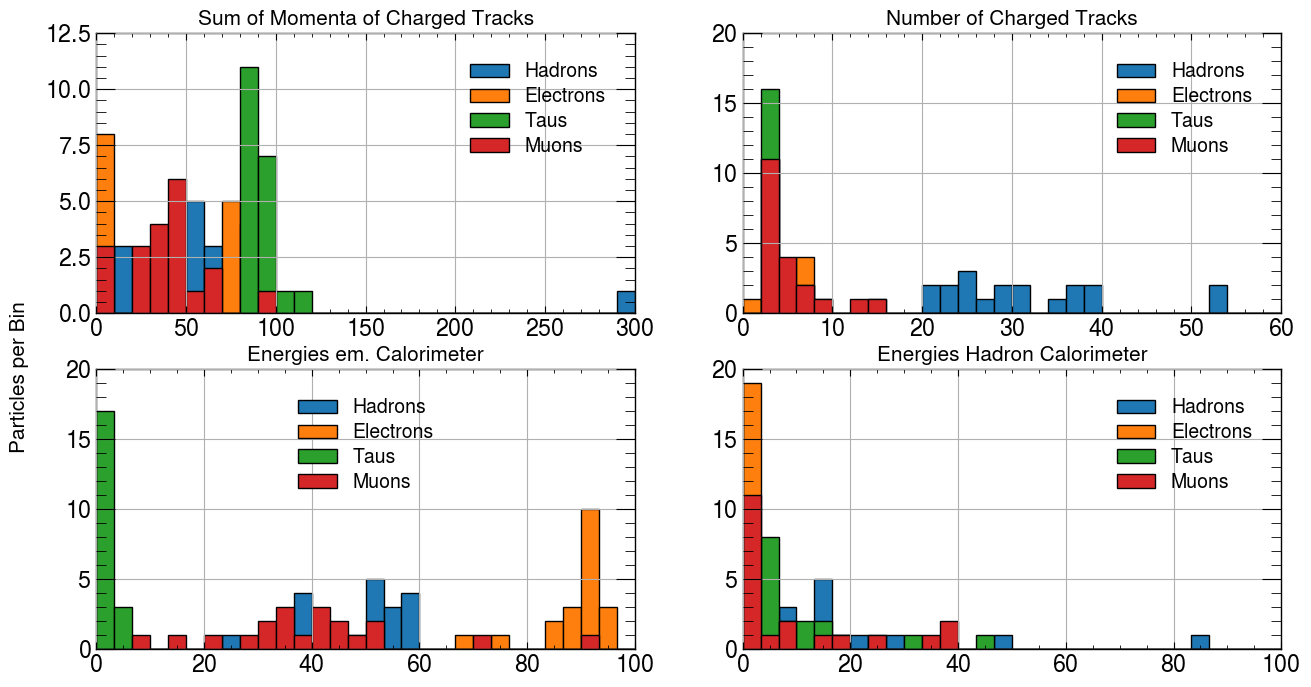

In [5]:
plt.style.use(mplhep.style.ATLAS)
fig, ax = plt.subplots(figsize = (15, 8))

title=['Sum of Momenta of Charged Tracks', 'Number of Charged Tracks', 'Energies em. Calorimeter', 'Energies Hadron Calorimeter']
label=['Hadrons', 'Electrons', 'Taus', 'Muons']
bins=[[15,8,3,10],[15,6,6,6],[10,10,2,15],[18,5,5,5]]
ranges=[(0,300),(0,60), (0,100), (0,100)]


fig.text(0.1025, 0.5, r'Particles per Bin', va='center', rotation='vertical', fontsize=15)
for i in [0,1,2,3]: # 0=charged track sump, 1=charged track N, E
    plt.subplot(221+i)
    plt.title(title[i], fontsize=15)
    for j in [0,1,2,3]:
        particle=[hadron[i], electron[i],muon[i],tau[i]]
        plt.hist(particle[j], bins=30, label=label[j],range=ranges[i], edgecolor='black',alpha=1)
    plt.grid()
    plt.legend()


In [6]:
###testing the cuts for Grope data

p=np.concatenate((hadron[0], electron[0], muon[0], tau[0]))
N=np.concatenate((hadron[1], electron[1], muon[1], tau[1]))
E=np.concatenate((hadron[2], electron[2], muon[2], tau[2]))
HE=np.concatenate((hadron[3], electron[3], muon[3], tau[3]))

#method 1
cp=count_particles(p,N,E,HE)
#this method throws some particles away and counts most of the time less particles than there actually are

print('numbers of hadrons, electron, taus, muons:',cp)

#method two counts in general more particles than there actually are
#method two is not displayed here but you can see the final result obtained for the cross sections below

numbers of hadrons, electron, taus, muons: [16 18 21 18]


# Evaluating data obtained by Monte Carlo simulation

In the frist part of the expoeriment we will investigate some simulations of Data sets with particles of known origin.

We will open data and Monte Carlo samples using **uproot**. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

You can find more info on uproot following the references:
* Github repo: https://github.com/scikit-hep/uproot4
* Tutorial: https://masonproffitt.github.io/uproot-tutorial/
* Video tutorial on uproot and awkward arrays:  https://www.youtube.com/embed/ea-zYLQBS4U 

First, let's specify the folder path for both data and Monte Carlo (MC) samples

## Procedure
In this section we want to get a rough estimate of how our counting algorithm works. Therefore we use the function we generated above for our cutting, to get a rough estimate of how many particles are actually counted wrong.

In the below discussion we did not include any errors, which we will get through the Poisson distribution.

Based on the new Histogramms, whcih are shown in the end of the chapter, we will define new cutting regions for our particles. We do poisson fits and then include alle data in a 3-sigma intervall. 

It turned out that the results provided by this method for the intervals, where to det the cuts is more bad, than just estimating by hand and screwing a bit with the parameters of the fit itself.

The last line shows all the variables available in the TTree to carry out the experiment. The meaning of these is described in the following table

| Variable name | Description |
| --- | --- | 
| <pre>run</pre> | Run number |
| <pre>event</pre> | Event number |
| <pre>Ncharged</pre> | Number of charged tracks |
| <pre>Pcharged</pre> | Total scalar sum of track momenta |
| <pre>E_ecal</pre> | Total energy measured in the electromagnetic calorimeter |
| <pre>E_hcal</pre> | Total energy measured in the hadronic calorimete |
| <pre>E_lep</pre> | LEP beam energy (=$\sqrt{s}/2$) |
| <pre>cos_thru</pre> | cosine of the polar angle between beam axis and thrust axis |
| <pre>cos_thet</pre> | cosine of the polar angle between incoming positron and outgoing positive particle |

We proceed to plot *PCharged* for illustration.

## Reading simulated data and creating efficiency matrix 

In [7]:
#matrix obtained using counting function 1
matrix=[]
error_matrix=[]
# matrix obtained using counting function 2
matrix2=[]
error_matrix2=[]

#list of criterias for each particle type (Nchar, ....)
criteria=[]


for i in ['qq.root','ee.root', 'tt.root','mm.root']:
    ### Open the file introducing file path
    file = uproot.open(path_data+i)
    ttree_name = 'myTTree'

    ### Print list of 'branches' of the TTree (i.e. list of variable names)
    file[ttree_name].keys()
    #print(file[ttree_name].keys())

    ## Load branches
    branches = file[ttree_name].arrays()

    ## Define an numpy array for 'Pcharged'
    Pcharged = 'Pcharged'
    NCharged='Ncharged'
    E_ecal='E_ecal'
    E_hcal='E_hcal'
    cos_thet='cos_thet'
    E_lep='E_lep'
    

    pchar = ak.to_numpy(branches[Pcharged]) # See Docu (https://awkward-array.org/how-to-convert-numpy.html) for more conversions
    Nchar = ak.to_numpy(branches[NCharged])
    E_ecal = ak.to_numpy(branches[E_ecal])
    E_hcal = ak.to_numpy(branches[E_hcal])
    cos_thet =ak.to_numpy(branches[cos_thet])
    E_lep = ak.to_numpy(branches[E_lep])
    
    criteria.append([pchar, Nchar, E_ecal, E_hcal, cos_thet,E_lep])
    
    cp,ph1,ph2,ph3=count_particles_simulated(pchar,Nchar,E_ecal,E_hcal,cos_thet) #ph= placeholder
    
    #inserting counted particle number divided through total particle number into the matrix
    matrix.append(cp/len(Nchar))
    
    
    #the errors are calculated assuming a poisson distribution of the counted numbers
    #which is justified since all considered 
    # numbers are larger than 30 which is considered as ''very large'' 
    error_matrix.append(np.sqrt(cp/len(Nchar)**2+cp**2/len(Nchar)**3))
    
    listen=np.array(np.full(4,0))
    cp=particletest(Nchar,pchar,E_ecal,E_hcal)
    matrix2.append(cp/len(Nchar))
    error_matrix2.append(np.sqrt(cp/len(Nchar)**2+cp**2/len(Nchar)**3))
    

matrix=np.array(matrix)
matrix2=np.array(matrix2)
error_matrix=np.array(error_matrix)   
error_matrix2=np.array(error_matrix2)


print('Efficiency matrix:')
print(matrix)
print('Error efficiency matrix:')
print(error_matrix)
print('Efficiency matrix 2:')
print(matrix2)
print('Error efficiency matrix 2:')
print(error_matrix2)

Efficiency matrix:
[[9.81412903e-01 6.29039295e-04 5.81354058e-03 0.00000000e+00]
 [0.00000000e+00 9.41664357e-01 4.75469606e-03 0.00000000e+00]
 [7.48605045e-03 1.81912288e-02 8.95927488e-01 5.04961244e-04]
 [0.00000000e+00 0.00000000e+00 8.39469809e-02 8.76521758e-01]]
Error efficiency matrix:
[[3.27996993e-03 7.99131927e-05 2.43569069e-04 0.00000000e+00]
 [0.00000000e+00 3.01403536e-03 2.25675988e-04 0.00000000e+00]
 [3.08563764e-04 4.83553713e-04 3.57806495e-03 7.98615390e-05]
 [0.00000000e+00 0.00000000e+00 9.81893248e-04 2.68515650e-03]]
Efficiency matrix 2:
[[9.72677374e-01 1.46200907e-02 1.29054513e-02 1.28851597e-03]
 [1.06607535e-05 9.91929810e-01 3.90183578e-03 4.16835462e-03]
 [6.04691090e-03 7.52266014e-02 9.05900472e-01 1.50099730e-02]
 [0.00000000e+00 3.37461989e-02 5.72996684e-02 9.08985919e-01]]
Error efficiency matrix 2:
[[3.23981250e-03 3.87944684e-04 3.64178327e-04 1.14410943e-04]
 [1.06608103e-05 3.26441836e-03 2.04349730e-04 2.11241647e-04]
 [2.77124504e-04 1.0104

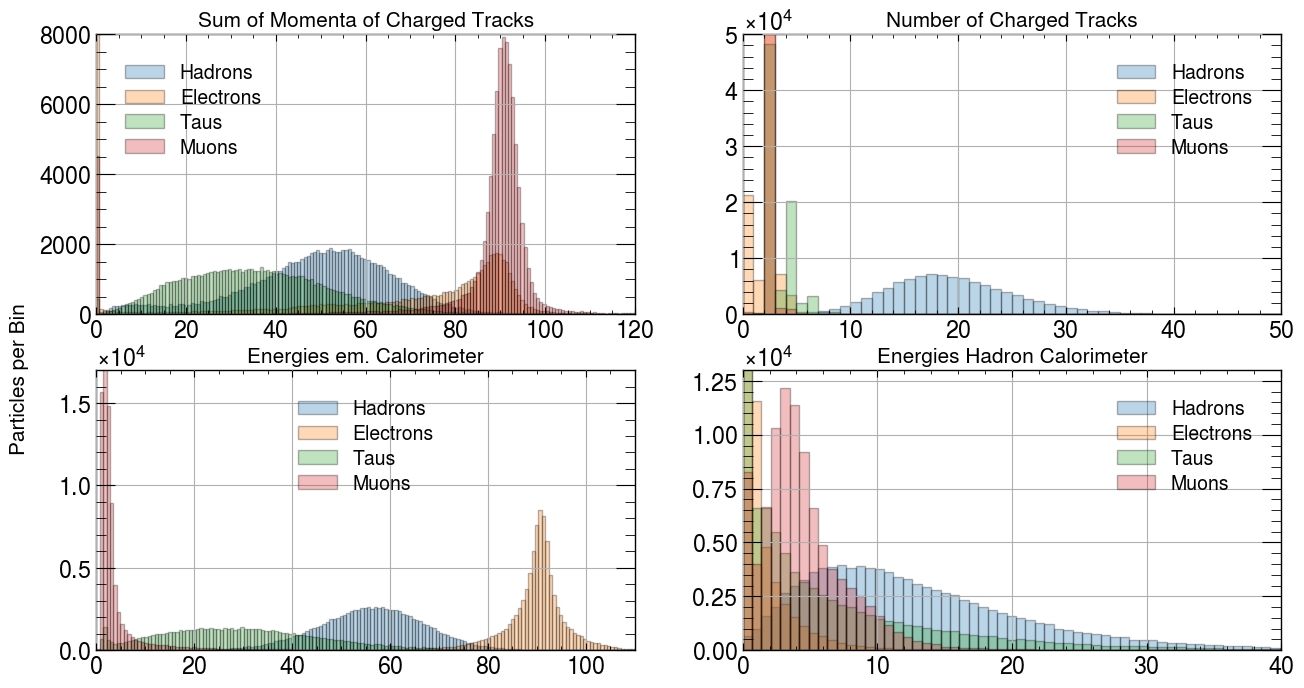

In [8]:
#all histograms in one


fig, ax = plt.subplots(figsize = (15, 8))
title=['Sum of Momenta of Charged Tracks', 'Number of Charged Tracks', 'Energies em. Calorimeter', 'Energies Hadron Calorimeter']
label=['Hadrons', 'Electrons', 'Taus', 'Muons']
xlim=[(0,120),(0,50), (0,110), (0,40)]
ylim=[(0,0.8e4),(0,0.5e5),(0,1.7e4),(0,1.3e4)]
#fig.text(0.55, 0.1, r'Center of Mass Energy [GeV]', ha='center', fontsize=15)
fig.text(0.1025, 0.5, r'Particles per Bin', va='center', rotation='vertical', fontsize=15)
bins=[200,140,200,200]

for i in [0,1,2,3]:
    plt.subplot(221+i)
    plt.title(title[i], fontsize=15)
    for j in [0,1,2,3]:
        particle=[criteria[0][i], criteria[1][i],criteria[2][i],criteria[3][i]]
        entries, bin_edges, patches=plt.hist(particle[j], bins=bins[i],range=(0.,140.), label=label[j], edgecolor='black',alpha=0.3)
        plt.xlim(xlim[i])
        plt.ylim(ylim[i])
    plt.legend()
    plt.grid()


### Exemplary gauss fits

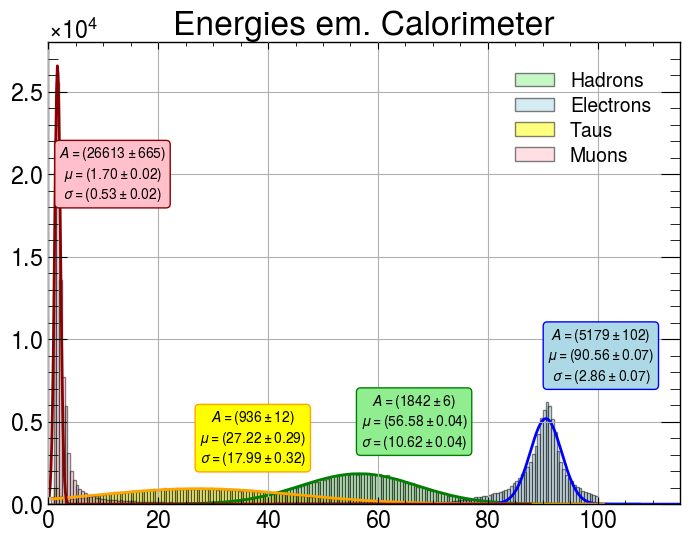

In [9]:
#one histogram with gauss fits

poptp0Ecal=([(0.3e4,55,20),(0.7e4,90,10),(0.1e4,35,40),(0,30,30)])
color=['lightgreen', 'lightblue', 'yellow', 'pink']
color2=['green', 'blue', 'orange', 'darkred']
testho=[0.5e4,0.9e4,0.4e4,2e4]
#KäsefürFehler=0.1
for i in [2]:
    plt.figure()
    plt.title(title[i])
    for j in [0,1,2,3]:
        particle=[criteria[0][i], criteria[1][i],criteria[2][i],criteria[3][i]]
        entries, bin_edges, patches=plt.hist(particle[j], bins=200,range=(0,100), label=label[j],color=color[j], edgecolor='black',alpha=0.5)
        x=np.linspace(min(particle[j]),max(particle[j]),600)
        bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        popt, pcov = curve_fit(gauss, bin_middles, entries,p0=poptp0Ecal[j],maxfev=10000)
        #popt2, pcov2=curve_fit(fit_function, bin_middles, entries, maxfev=1000000)         
        #plt.plot(x,fit_function(x,*popt2))
        plt.plot(x,gauss(x,*popt), color=color2[j])
       # print('___________________________________________________________________________________________________________________')
       # print('Die fitparameter der Gaußfunktion des Histograms', label[j],'mit zugehörigen Fehlern lauten:','\n'.join((
       # r'$A=(%.3f \pm %.3f)$' % (popt[0],np.sqrt(pcov[0][0]), ),
       # r'$\mu=(%.3f \pm %.3f)$' % (popt[1],np.sqrt(pcov[1][1]), ),
       # r'$\sigma=(%.3f \pm %.3f)$' % (popt[2],np.sqrt(pcov[2][2]), ),)))
       # print('Als Cutting bereich für', title[i],'für', label[j],'wählen wir die Bereiche:',popt[1]-3*abs(popt[2]),popt[1]+3*abs(popt[2]))
       # print('___________________________________________________________________________________________________________________')
        #redchi=redchi2(entries,gauss(bin_middles,*popt),np.sqrt(entries)+KäsefürFehler,3)


        textstr = '\n'.join((
            r'$A=(%.0f \pm %.0f)$' % (popt[0],np.sqrt(pcov[0][0]), ),
            r'$\mu=(%.2f \pm %.2f)$' % (popt[1],np.sqrt(pcov[1][1]), ),
            r'$\sigma=(%.2f \pm %.2f)$' % (popt[2],np.sqrt(pcov[2][2]), )))
           # r'$\chi^2_{red}=%.1f$' % (redchi, )))

        plt.text(popt[1]+10, testho[j], textstr, size=10,ha="center",
            va="center",bbox=dict(boxstyle="round",facecolor=color[j], edgecolor=color2[j], ), color='black')
        
        plt.xlim(0,115)
        plt.ylim(0,2.8e4)
    plt.legend()
    plt.grid()


### Single histograms for appendix

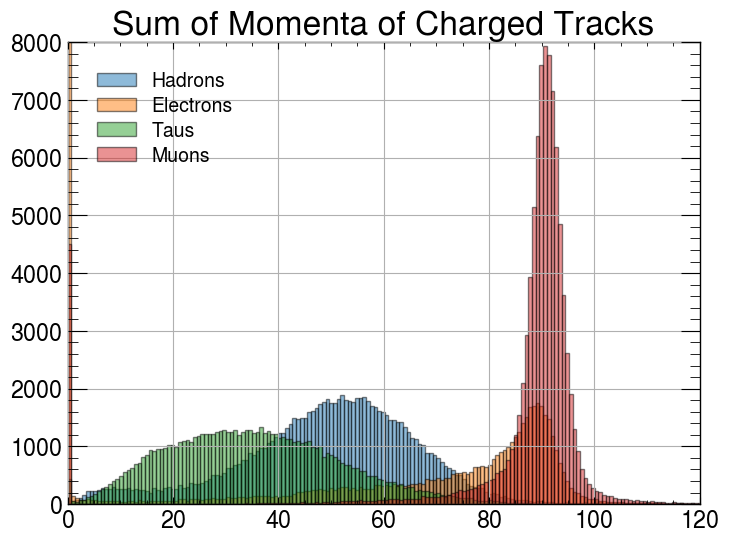

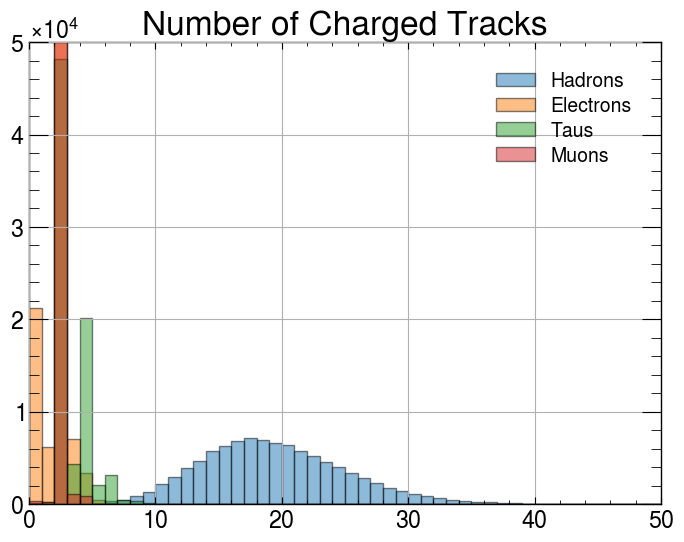

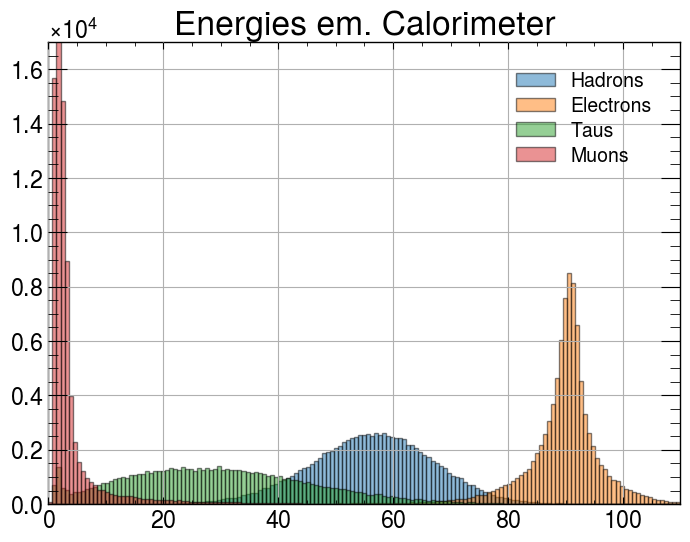

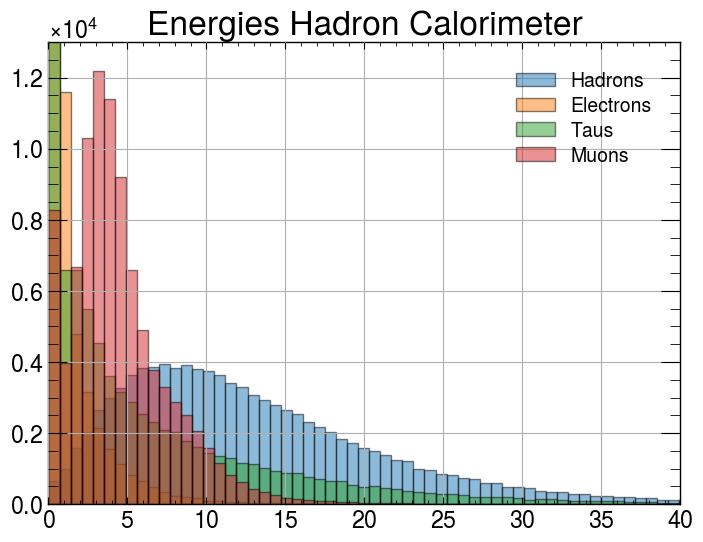

In [10]:
for i in [0,1,2,3]:
    plt.figure()
    plt.title(title[i])
    for j in [0,1,2,3]:
        particle=[criteria[0][i], criteria[1][i],criteria[2][i],criteria[3][i]]
        entries, bin_edges, patches=plt.hist(particle[j],bins=bins[i],range=(0.,140.), edgecolor='black', label=label[j],alpha=0.5)
        plt.ylim(ylim[i])
        plt.xlim(xlim[i])
    plt.legend()
    plt.grid()

## Matrix Inversion
To determine the uncertainties of the matrix elements after the inversion we use Monte Carlo toy experiments. In this context, what are the advantages and disadvantages of this method when compared to analytical expressions? Discuss it briefly.

**References**:
* Propagation of Errors for Matrix Inversion: https://arxiv.org/abs/hep-ex/9909031v1

In [11]:
### Number of toy experiments to be done
ntoy = 1000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4))

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    #np.random.seed(2)
    toy_matrix = np.random.normal(matrix,error_matrix,size=(4,4))
    
    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    #print(inverse_toys.item(0,0),inverse_toy.item(0,0))
    # Append values
    
    inverse_toys = np.dstack((inverse_toys,inverse_toy))

Erros for the inverse matrix:
[[3.38333067e-03 8.11720680e-05 2.80158707e-04 6.55275716e-07]
 [2.51506498e-06 3.45521947e-03 2.77950620e-04 5.37050918e-07]
 [3.29345679e-04 5.85160483e-04 4.37697157e-03 1.06523328e-04]
 [3.53986470e-05 5.97653074e-05 1.44874730e-03 3.25533758e-03]]


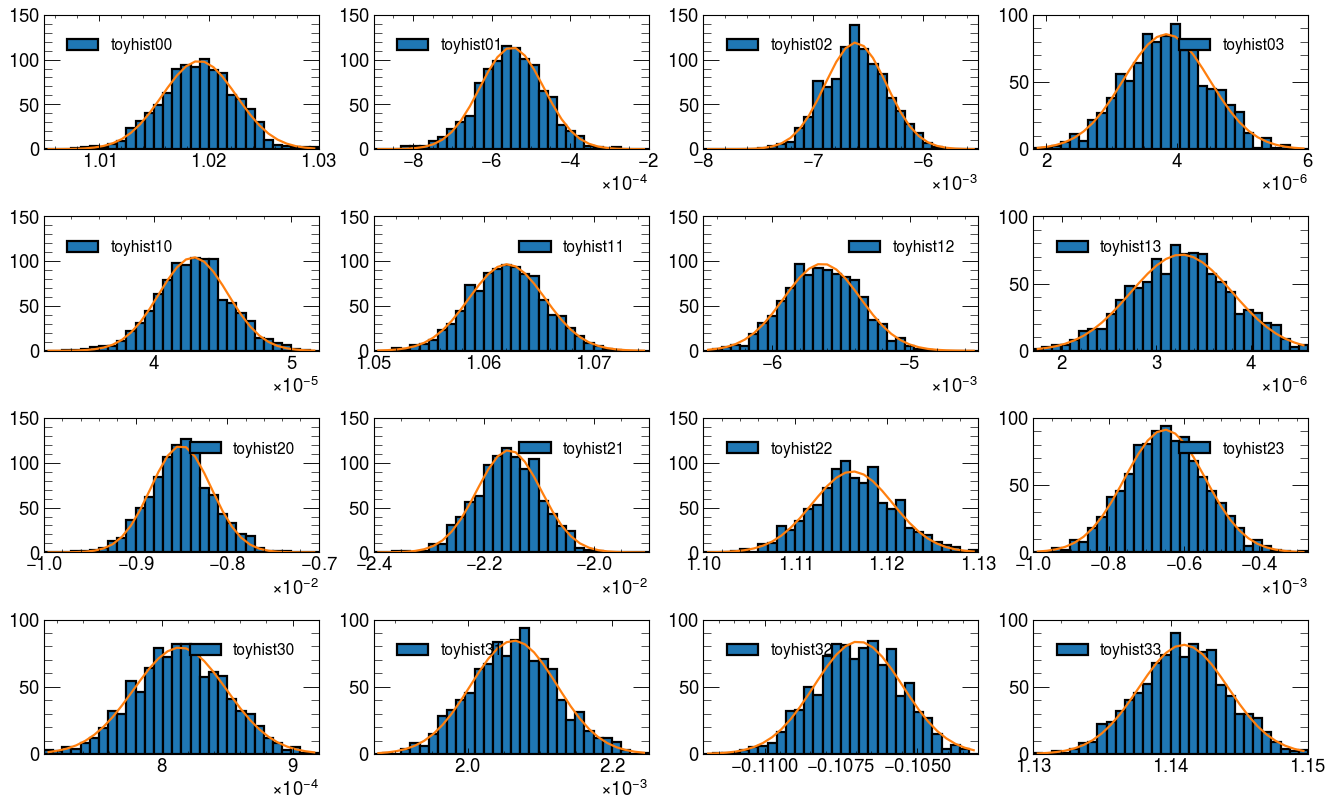

In [12]:
# Define gaussian function to fit to the toy distributions:



inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))


fig = plt.figure(figsize=(20, 12),dpi=80)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
#fig.tight_layout()
ax00 = plt.subplot(4,4,1)
ax01 = plt.subplot(4,4,2)
ax02 = plt.subplot(4,4,3)
ax03 = plt.subplot(4,4,4)

ax10 = plt.subplot(4,4,5)
ax11 = plt.subplot(4,4,6)
ax12 = plt.subplot(4,4,7)
ax13 = plt.subplot(4,4,8)

ax20 = plt.subplot(4,4,9)
ax21 = plt.subplot(4,4,10)
ax22 = plt.subplot(4,4,11)
ax23 = plt.subplot(4,4,12)

ax30 = plt.subplot(4,4,13)
ax31 = plt.subplot(4,4,14)
ax32 = plt.subplot(4,4,15)
ax33 = plt.subplot(4,4,16)

axes = [[ax00,ax01,ax02,ax03],
        [ax10,ax11,ax12,ax13],
        [ax20,ax21,ax22,ax23],
        [ax30,ax31,ax32,ax33]]

## IMPORTANT! Find suitable ranges to fit/plot gaussian distributions successfully!
ranges = [[(1.005,1.03)   ,(-0.0009,-0.0002), (-0.008,-0.0055), (0.0000018,0.000006)],
          [(0.000032,0.000052),(1.05,1.075)   , (-0.0065,-0.0045), (0.0000017,0.0000046)],
          [(-0.01,-0.007),(-0.024,-0.019), (1.1,1.13)   , (-0.001,-0.00027)],
          [(0.00071,0.00092),(0.00187,0.00225), (-0.112,-0.103), (1.13,1.15)]]


p0=[[[15,1.02,0.05],[20,-0.00055,0.00001],None, [26,0.000004,0.000001]],
    [[20,0.000044,0.000002],[20,1.062,0.004],None,[25,0.0000035,0.0000005]],
   [[110,-0.0085,0.0005],None,None,[28,-0.0007,0.00005]],
  [[90,8.2e-4,0.5e-4], [90,2.1e-3,0.5e-3], None, None]]

# Fill histograms for each inverted matrix coefficient:
for j in range(0,4,1):
    for k in range(0,4,1):
        
        # Diagonal and off-diagonal terms have different histogram ranges
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j,k,:],bins=30,range=ranges[j][k], edgecolor='black', linewidth=2, label=f'toyhist{j}{k}')
        axes[j][k].legend()

        ## Guess initial parameters of the fit by taking random value from hist and std
        _p0 = [ntoy/10.,np.mean(inverse_toys[j,k,:]),np.std(inverse_toys[j,k,:])]

        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins, maxfev=10000,p0=p0[j][k])
        h_fit = gauss(h_mid, *coeffs)
        
        axes[j][k].plot(h_mid, h_fit,label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])
        axes[j][k].set_xlim(ranges[j][k])

print(f"Erros for the inverse matrix:\n{inverse_errors}")

In [13]:
#Calculate inverse matrices for the first counting methods (count_particles_simulated)

inverse_matrix1=np.linalg.inv(matrix)
inverse_matrix2=np.linalg.inv(matrix2)

print(f"The inverse matrix:\n{np.linalg.inv(matrix)}")
print(f"Erros for the inverse matrix:\n{inverse_errors}")

The inverse matrix:
[[ 1.01898954e+00 -5.53009827e-04 -6.60949390e-03  3.80770727e-06]
 [ 4.29975998e-05  1.06205837e+00 -5.63693761e-03  3.24742085e-06]
 [-8.51564572e-03 -2.15609522e-02  1.11639170e+00 -6.43149514e-04]
 [ 8.15567603e-04  2.06495370e-03 -1.06920007e-01  1.14093459e+00]]
Erros for the inverse matrix:
[[3.38333067e-03 8.11720680e-05 2.80158707e-04 6.55275716e-07]
 [2.51506498e-06 3.45521947e-03 2.77950620e-04 5.37050918e-07]
 [3.29345679e-04 5.85160483e-04 4.37697157e-03 1.06523328e-04]
 [3.53986470e-05 5.97653074e-05 1.44874730e-03 3.25533758e-03]]


## Reading in OPAL data

In [14]:
#defining new criteria list

criteria2=[]



#actual energies found in data
#we obtained these energies by outputting E_lep and picking out all different energies
#then we rounded these eneregies up to one number after the comma
#these gave us the seven energy values we are interested in

energy=[88.4,89.4,90.2,91.2,92,93,93.8]

##########################################

for i in range(0, len(energy)):
    ### Open the file introducing file path
    file = uproot.open(path_data+'daten_2.root')
    ttree_name = 'myTTree'

    ### Print list of 'branches' of the TTree (i.e. list of variable names)
    file[ttree_name].keys()
    #print(file[ttree_name].keys())

    ## Load branches
    branches = file[ttree_name].arrays()

    ## Define an numpy array for 'Pcharged', etc.
    Pcharged = 'Pcharged'
    NCharged='Ncharged'
    E_ecal='E_ecal'
    E_hcal='E_hcal'
    cos_thet='cos_thet'
    E_lep ='E_lep'
    pchar = ak.to_numpy(branches[Pcharged]) # See Docu (https://awkward-array.org/how-to-convert-numpy.html) for more conversions
    Nchar = ak.to_numpy(branches[NCharged])
    E_ecal = ak.to_numpy(branches[E_ecal])
    E_hcal = ak.to_numpy(branches[E_hcal])
    cos_thet =ak.to_numpy(branches[cos_thet])
    E_lep = ak.to_numpy(branches[E_lep])
    
    ################################################
    #sorting the single criteria by the energies from the list above
    #by checking wether their E_lep entry equals the energy of the list which is considered in this for loop

    pchar=np.where(np.around(E_lep,1)==energy[i]/2, pchar, 'hey')
    
    #### all pchar entries whoms corresponding energy does not fit are replaced by 'hey', and removed from the list in the
    #next step
    pchar= np.asarray(pchar[pchar != 'hey'], dtype=np.float64)
    
    #this, we repeat for all criterias
    
    Nchar=np.where(np.around(E_lep,1)==energy[i]/2, Nchar, 'hey')
    Nchar= np.asarray(Nchar[Nchar != 'hey'], dtype=np.float64)
    E_ecal=np.where(np.around(E_lep,1)==energy[i]/2, E_ecal, 'hey')
    E_ecal= np.asarray(E_ecal[E_ecal != 'hey'], dtype=np.float64)
    E_hcal=np.where(np.around(E_lep,1)==energy[i]/2, E_hcal, 'hey')
    E_hcal=np.asarray(E_hcal[E_hcal != 'hey'], dtype=np.float64)
    cos_thet=np.where(np.around(E_lep,1)==energy[i]/2, cos_thet, 'hey')
    cos_thet= np.asarray(cos_thet[cos_thet != 'hey'], dtype=np.float64)
    
    #again we include into criteria all the criteria for all the particles for all the energies
    # thus critera[num] gives all entries for one energy,
    #for one energy and criteria[num][num] the actual criteria for all particles for the considered energy
    criteria2.append([pchar, Nchar, E_ecal, E_hcal, cos_thet])


# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

## Seperation for simulated data

efficiency: (0.936 +/- 0.052)
fixing ratio: 1.837


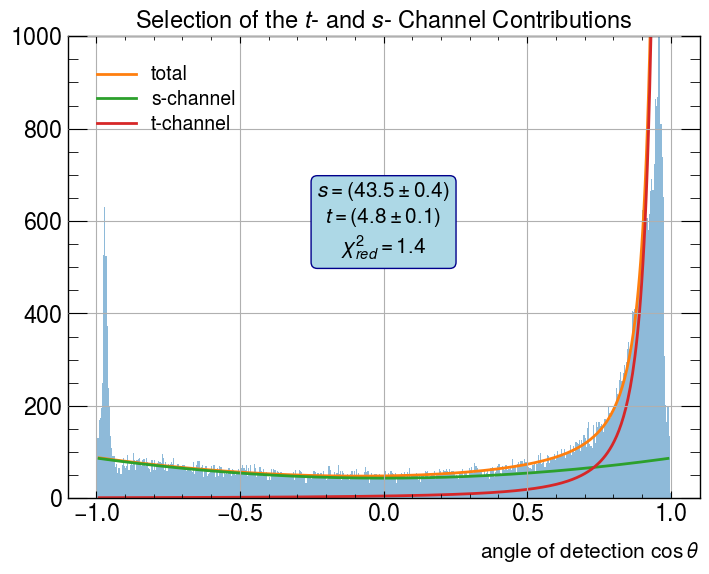

In [15]:
#in order to seperate s- and t-channel we fit the below function onto a part of the histogram
#and use each summend of the function to sepearte s- and t-channel since one summand described s- and the other t-channel


plt.figure()
plt.title(r'Selection of the $t$- and $s$- Channel Contributions', fontsize=17)
plt.xlabel(r'angle of detection $\cos{\theta}$', fontsize=15)
    
entries, bin_edges, patches=plt.hist(criteria[1][4], bins=500,range=(-1,1),alpha=0.5)
x=np.linspace(-0.99,0.99,len(entries))
    
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

popt, pcov= curve_fit(f,bin_middles[17:-20],entries[17:-20],sigma=np.sqrt(entries[17:-20]),p0=[60.7,7.2], maxfev=2000)
plt.plot(x, f(x, *popt), label='total')
plt.plot(x, popt[0]*(1+x**2), label='s-channel')
plt.plot(x, popt[1]/(1-x)**2, label='t-channel')
         
         
redchi=redchi2(entries[17:-20],f(bin_middles[17:-20],*popt),np.sqrt(entries[17:-20]),2)


textstr = '\n'.join((
    r'$s=(%.1f \pm %.1f) $' % (popt[0],np.sqrt(pcov[0][0]), ),
    r'$t=(%.1f \pm %.1f) $ ' % (popt[1],np.sqrt(pcov[1][1]), ),
    r'$\chi^2_{red}=%.1f$' % (redchi, )))

plt.text(0, 600, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')

plt.xlim(-1.1,1.1)
plt.ylim(0,1000)
plt.legend()
plt.grid()


#Calculating the factor to pick out s-channel contributions
#########################################################################
#first try:

u=1
l=-1

#we calculate the efficiency by dividing the integral of the s-channel function from -1 to 1
#by the overall number of counted particles divided by bin_number/interval length(=500/2)


#we calll the efficiency ''cleaned'' because we consider the simualted data where we know for sure that we are considering 
#electrons

efficiency_clean=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/(sum(entries)/250)

#this efficiency is however not used since it does not yield good results
#the cross section vs mean energy plot for electrons becomse different (the first two cross sections are to high)
######################################################################
#second try: cutting method

#in order to fix the problem mentioned above we chose the simply cut a part out of the plot which yields a high efficiency:

#interval limits:
u=limit
l=-0.9
# thus we throw away all electrons which have a costheta larger than u and smaller than l


efficiency_clean2=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/(sum(entries[25:300])/250)

c1=((u+1/3*u**3)-(l+1/3*l**3))
c2=(1/(1-u)-1/(1-l))

# instead of dividing by the total number of counted particles we integrate the fit function f(..)
# from l to u and divide by the hereby obtained number to get the efficiency

efficiency_clean3=(popt[0]*c1)/(popt[0]*c1+popt[1]*c2)
defficiency_clean3=np.sqrt((efficiency_clean3**2*c2)**2*pcov[1][1]+((efficiency_clean3**2*c1/(popt[0]))**2*pcov[0][0]))
#this last version is the one we will use in the following

######################################################################################
#recovering what we lose due to wrong assigment while detecting (data with costheta=999)
#beta=len(cos_thet_ee)/sum(entries)
#dbeta=np.sqrt(len(cos_thet_ee)/sum(entries)**2+(len(cos_thet_ee)/sum(entries)**2)**2*sum(entries))
# Note cos_thet_ee is defined in the following
#we omit this idea since multiplying the electron number by this
# worsens the result
#which is probably due to the fact that most of the wrongly assigned electrons are t-channel electrons

############################################################################################
#in order to fix the electron number by the number of ''interference'' electrons we have just cut out/removed in the above
#step, we calculate the ratio of the integral of the s-channel function over the whole interval and the integral over the
#limits we have chosen above

uu=1
ll=-1
a=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))
b=popt[0]*((uu+1/3*uu**3)-(ll+1/3*ll**3))

ratio=b/a
#this ratio does not have an error since it only depends on the chosen limits

print('efficiency: (%.3f +/- %.3f)'%(efficiency_clean3,defficiency_clean3) )
print('fixing ratio: %.3f' %(ratio))


###Notes:
#beta was removed since it lead to wrong values, so the electrons which
#were not correctly registered by the detetor should indeed not be considered
#since they are probably mostly t-channel contributions, i.e. have very smaller theta values, such that the detector
#can not measure them
#(thats why the electron cross section is still as large as muon and taon cross section although we threw away half of the
#electrons
####################################
#note that changeing the integral limits changes the Z-mass for electrons, the smaller, the better
#it also changes the line width of all fermions, when trying to optimize the electron line width by making the
#intervall smaller, tau and muon line width worsen, thus one has to find a compromis

#moreover the number of leptons depends strongly on these intervals, such that enlarging the interval by a small amount
#yields two instead of three neutrinos

##################################
#we also tried to multiply the efficiency to the initial matrix, i.e. before inverting but this did not really yield 
#better results, it worsened the results for tau and muon but made them be less dependend of the cut interval for the
#t-s-channel seperation since here the actual electron entries were corrected in the matrix (before inverting), such that 
#the muon and tuon entries do not get effected this much....

######
#systematic errors: by cutting of an interval for s-t-channel, interference terms are neglected, this might lead to some
#deviation
#moreover half of the electrons are not measured correctly, this just leads to smaller number of overall electrons but
#correcting this by multiplying with beta worsens the cross-section.

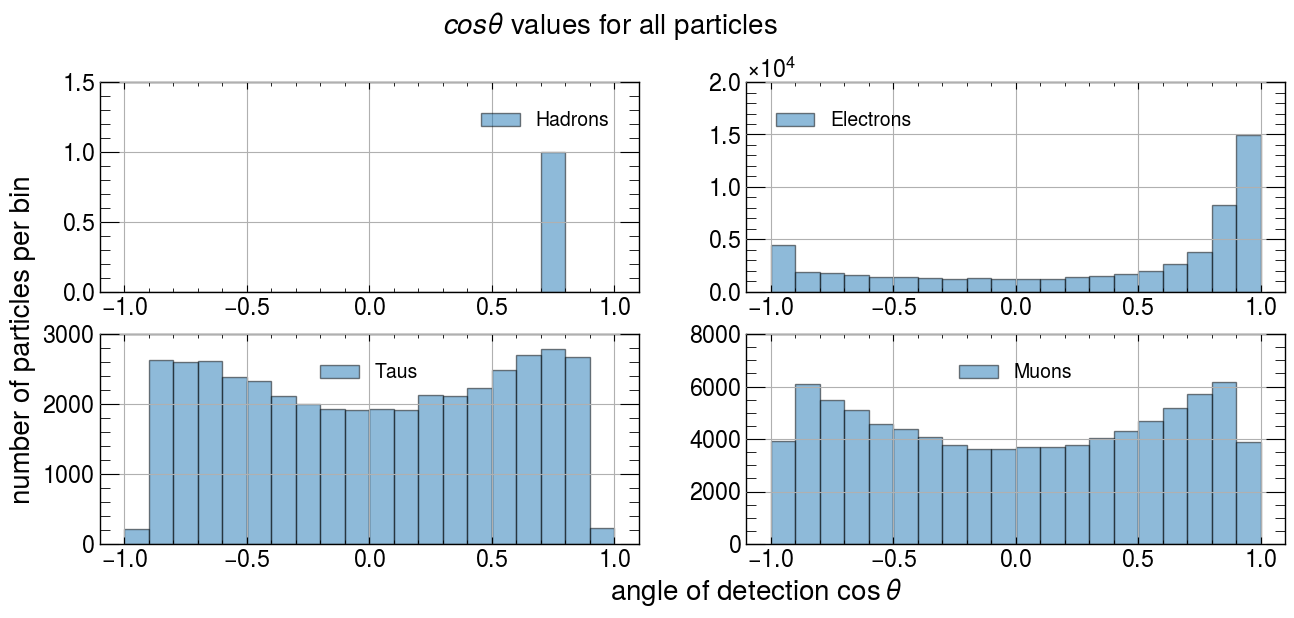

In [16]:
#angular distribution for all particles 
#the hadron's distribution looks like this since most of the hadron's costheta are set to 999
#the number of misassignments in the hadronic channel is very large


fig, ax = plt.subplots(figsize = (15, 6))
plt.suptitle(r'$cos \theta $ values for all particles', fontsize=20, y=1.05)
fig.text(0.5, 0.08,r'angle of detection $\cos{\theta}$', va='center', rotation='horizontal', fontsize=20)
fig.text(0.1, 0.5, r'number of particles per bin', va='center', rotation='vertical', fontsize=20)
label=['Hadrons', 'Electrons', 'Taus', 'Muons']
for i in [0,1,2,3]:
    plt.subplot(221+i)
    entries, bin_edges, patches=plt.hist(criteria[i][4], bins=20,range=(-1,1),edgecolor='black',alpha=0.5, label=label[i])
    x=np.linspace(-0.99,0.99,len(entries))

    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    plt.xlim(-1.1,1.1)
    #plt.ylim(0,1000)
    plt.legend()
    plt.grid()

## Seperation for OPAL data

In [17]:
#creating a list of the cos_theta values of electrons and a list including only s-channel electrons

cos_thet_e=[]
e_s_channel=[]
for i in range(0, 7):
    ph1, cos_thet_e_i, ph2, e_s_channel_i=(count_particles_simulated(criteria2[i][0],criteria2[i][1],criteria2[i][2],criteria2[i][3],criteria2[i][4]))

    
    cos_thet_e.append(cos_thet_e_i)
    e_s_channel.append(e_s_channel_i)


#since the cos_thet_e obtained above are seperated by their energies they have to be merged:
cos_thet_ee=np.concatenate((cos_thet_e[0],cos_thet_e[1],cos_thet_e[2],cos_thet_e[3],cos_thet_e[4],cos_thet_e[5],cos_thet_e[6]))


ee_s_channel=np.concatenate((e_s_channel[0],e_s_channel[1],e_s_channel[2],e_s_channel[3],e_s_channel[4],e_s_channel[5],e_s_channel[6]))

#picking out the cos_thet values from the s-channel electron data:

cos_thet_s_channel=[]

for i in range(0,len(ee_s_channel)):
    cos_thet_s_channel.append(ee_s_channel[i][4])

efficiency: (0.923 +/- 0.113)
fixing ratio: 1.837


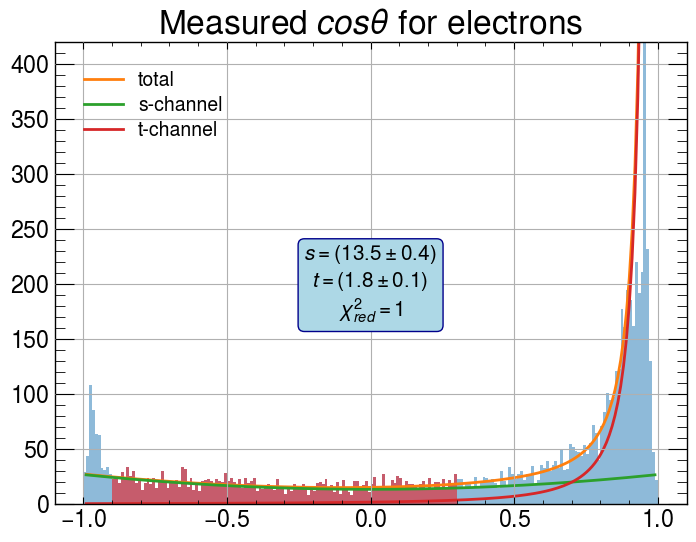

In [18]:
plt.figure()
plt.title(r'Measured $cos \theta $ for electrons')

bins=200

#creating a histogram for all electrons and the electrons picked out for being most probably s-channel electrons (red)
entries, bin_edges, patches=plt.hist(cos_thet_ee, bins=bins,range=(-1,1),alpha=0.5)
entries2, bin_edges2, patches=plt.hist(cos_thet_s_channel, bins=200,range=(-1,1),alpha=0.5, color='red')


x=np.linspace(-0.99,0.99,len(entries))
    
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_middles2 = 0.5 * (bin_edges2[1:] + bin_edges2[:-1])

#Fit
popt, pcov= curve_fit(f,bin_middles[17:-20],entries[17:-20],sigma=np.sqrt(entries[17:-20]),p0=[60.7,7.2], maxfev=2000)


plt.plot(x, f(x, *popt), label='total')
plt.plot(x, popt[0]*(1+x**2), label='s-channel')
plt.plot(x, popt[1]/(1-x)**2, label='t-channel')         
         


redchi=redchi2(entries[17:-20],f(bin_middles[17:-20],*popt),np.sqrt(entries[17:-20]))


textstr = '\n'.join((
    r'$s=(%.1f \pm %.1f) $' % (popt[0],np.sqrt(pcov[0][0]), ),
    r'$t=(%.1f \pm %.1f) $ ' % (popt[1],np.sqrt(pcov[1][1]), ),
    r'$\chi^2_{red}=%.0f$' % (redchi, )))

plt.text(0, 200, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')



plt.xlim(-1.1,1.1)
plt.ylim(0,420)
plt.legend()
plt.grid()

u=limit

l=-0.9

#efficiency obtained using method 3 from above
#"dirty" because the data includes wrongly assigned electrons

c1=((u+1/3*u**3)-(l+1/3*l**3))
c2=(1/(1-u)-1/(1-l))

efficiency_dirty3=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/((popt[0]*((u+1/3*u**3)-(l+1/3*l**3))+popt[1]/(1-u)-popt[1]/(1-l)))
defficiency_dirty3=np.sqrt((efficiency_dirty3**2*c2)**2*pcov[1][1]+((efficiency_dirty3**2*c1/(popt[0]))**2*pcov[0][0]))

#recovering what we lose due to wrong assigment
#beta=len(cos_thet_ee)/sum(entries)     #omitted
#dbeta=np.sqrt(len(cos_thet_ee)/sum(entries)**2+(len(cos_thet_ee)/sum(entries)**2)**2*sum(entries))


#Calculating the ratio like above
uu=1
ll=-1
a=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))
b=popt[0]*((uu+1/3*uu**3)-(ll+1/3*ll**3))
ratio_dirty=b/a

print('efficiency: (%.3f +/- %.3f)'%(efficiency_dirty3,defficiency_dirty3) )
print('fixing ratio: %.3f' %(ratio_dirty))


#since the data contains misassigned electrons we will use the efficiency and ratio calculated above (from the simulation)
#although the obtained results are almost the same

In [19]:
#beta was removed since it lead to wrong values, so the electrons which
#were not correctly registered by the detetor should indeed not be considered
#since they are probably mostly t-channel contributions, i.e. have very smaller theta values, such that the detector
#can not measure them
#(thats why the electron cross section is still as large as muon and taon cross section although we threw away half of the
#electrons
####################################
#note that changeing the integral limits changes the Z-mass for electrons, the smaller, the better
#it also changes the line width of all fermions, when trying to optimize the electron line width by making the
#intervall smaller, tau and muon line width worsen, thus one has to find a compromis

#moreover the number of leptons depends strongly on these intervals, such that enlarging the interval by a small amount
#yields two instead of three neutrinos

##################################
#we also tried to multiply the efficiency to the initial matrix, i.e. before inverting but this did not really yield 
#better results, it worsened the results for tau and muon but made them be less dependend of the cut interval for the
#t-s-channel seperation since here the actual electron entries were corrected in the matrix (before inverting), such that 
#the muon and tuon entries do not get effected this much....

######
#systematic errors: by cutting of an interval for s-t-channel, interference terms are neglected, this might lead to some
#deviation
#moreover half of the electrons are not measured correctly, this just leads to smaller number of overall electrons but
#well it worsens the cross-section.


#### Both plots from above next to each other for protocoll

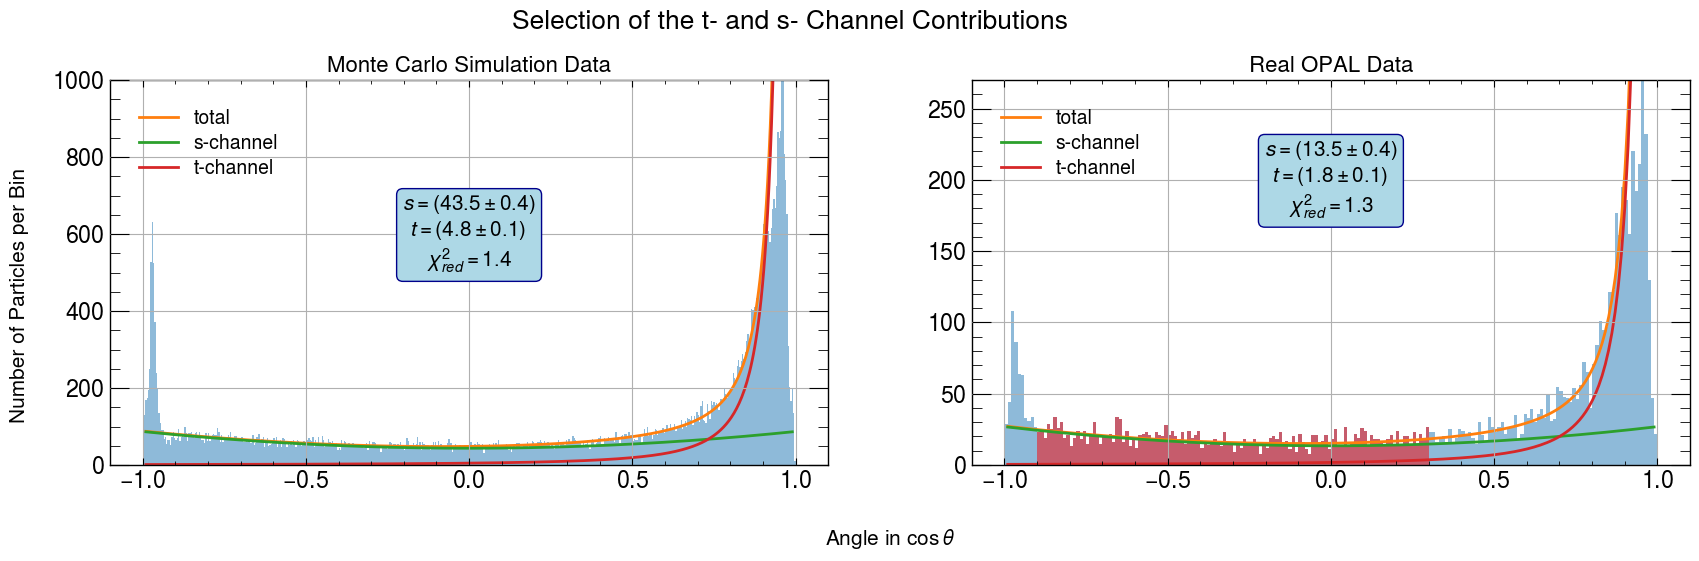

In [20]:
fig, ax = plt.subplots(figsize = (20, 5))
plt.suptitle('Selection of the t- and s- Channel Contributions',y=1.07, size=19)
fig.text(0.55, 0, r'Angle in $\cos{\theta}$', ha='center', fontsize=15)
fig.text(0.11, 0.5, r'Number of Particles per Bin', va='center', rotation='vertical', fontsize=15)


plt.subplot(121)
entries1, bin_edges1, patches1=plt.hist(criteria[1][4], bins=500,range=(-1,1),alpha=0.5)
x=np.linspace(-0.99,0.99,len(entries1))
    
bin_middles1 = 0.5 * (bin_edges1[1:] + bin_edges1[:-1])
popt1, pcov1= curve_fit(f,bin_middles1[17:-20],entries1[17:-20],sigma=np.sqrt(entries1[17:-20]),p0=[60.7,7.2], maxfev=2000)
plt.plot(x, f(x, *popt1), label='total')
plt.plot(x, popt1[0]*(1+x**2), label='s-channel')
plt.plot(x, popt1[1]/(1-x)**2, label='t-channel')
plt.grid()
plt.legend()
plt.title('Monte Carlo Simulation Data', fontsize=16)
plt.xlim(-1.1,1.1)

         
         
redchi1=redchi2(entries1[17:-20],f(bin_middles1[17:-20],*popt1),np.sqrt(entries1[17:-20]),2)


textstr = '\n'.join((
    r'$s=(%.1f \pm %.1f) $' % (popt1[0],np.sqrt(pcov1[0][0]), ),
    r'$t=(%.1f \pm %.1f) $ ' % (popt1[1],np.sqrt(pcov1[1][1]), ),
    r'$\chi^2_{red}=%.1f$' % (redchi1, )))

plt.text(0, 600, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')

plt.ylim(0,1000)
plt.subplot(122)
bins=200
entries, bin_edges, patches=plt.hist(cos_thet_ee, bins=bins,range=(-1,1),alpha=0.5)
entries2, bin_edges2, patches=plt.hist(cos_thet_s_channel, bins=200,range=(-1,1),alpha=0.5, color='red')
x=np.linspace(-0.99,0.99,len(entries))
    
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_middles2 = 0.5 * (bin_edges2[1:] + bin_edges2[:-1])

popt, pcov= curve_fit(f,bin_middles[17:-20],entries[17:-20],sigma=np.sqrt(entries[17:-20]),p0=[60.7,7.2], maxfev=2000)
plt.plot(x, f(x, *popt), label='total')
plt.plot(x, popt[0]*(1+x**2), label='s-channel')
plt.plot(x, popt[1]/(1-x)**2, label='t-channel')         
         

redchi=redchi2(entries[17:-20],f(bin_middles[17:-20],*popt),np.sqrt(entries[17:-20]))


textstr = '\n'.join((
    r'$s=(%.1f \pm %.1f) $' % (popt[0],np.sqrt(pcov[0][0]), ),
    r'$t=(%.1f \pm %.1f) $ ' % (popt[1],np.sqrt(pcov[1][1]), ),
    r'$\chi^2_{red}=%.1f$' % (redchi, )))

plt.text(0, 200, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')


plt.title('Real OPAL Data', fontsize=16)
plt.xlim(-1.1,1.1)
plt.ylim(0,270)
plt.legend()
plt.grid()

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [21]:
#corrections for the single channels and the mean_enegy, luminosity from the csv file
corr_hadr=[2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6]
corr_lep=[0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]
mean_energy, lumi,lumi_stat, lumi_sys, lumi_alll=CSV('daten_2.csv')

#lit value for Mz
Mz_lit =91.1876
dMz_lit=0.0021

In [22]:
hadron1=[]
ele1=[]
muon1=[]
tau1=[]
dhadron1=[]
dele1=[]
dmuon1=[]
dtau1=[]
dhadron1_sys=[]
dele1_sys=[]
dmuon1_sys=[]
dtau1_sys=[]
hadron2=[]
ele2=[]
muon2=[]
tau2=[]
#cos_thet_e=[]
cos_thet_muon=[]
e_s_channel=[]

#defining a vector for the correction of the electron number
#to pick out s-channel electrons and correcting for interference part electrons
s_channel_vec=np.array([1,ratio*efficiency_clean3, 1,1])
ds_channel_vec=np.array([0,ratio*np.sqrt((defficiency_clean3)**2),0,0])

#matrix3=np.copy(matrix)
#matrix3[1]=matrix[1]*efficiency_clean3
#inverse_matrix1=np.linalg.inv(matrix)


for i in range(0, 7):

    num1, ph1, cos_thet_muon_i, e_s_channel_i=(count_particles_simulated(criteria2[i][0],criteria2[i][1],criteria2[i][2],criteria2[i][3],criteria2[i][4]))
    
    e_s_channel.append(e_s_channel_i)
    
    #replace number total electron number by number of s-channel electrons
    num1[1]=len(e_s_channel[i])
    num1=np.array(num1)

    #creating a list for the costheta of muons for the calculation of the asymmetry factor and the Weinber angle
    cos_thet_muon.append(cos_thet_muon_i)
    
    #using the second counting function
    num2=(particletest(criteria2[i][1],criteria2[i][0],criteria2[i][2],criteria2[i][3]))

    

    
    #Define vector containing corrections on cross section for different channels
    corr_vec=np.array([corr_hadr[i], corr_lep[i],corr_lep[i], corr_lep[i]])
    
    #multiplying inverse matrix to number vector
    #correcting for s-channel electrons 
    #deviding ny the luminosities for the respective mean energy
    #adding corrections on single channels
    
    sigma_clean1=np.dot(inverse_matrix1,num1)*s_channel_vec/lumi[i]+corr_vec
    
    #statistical error on cross section
    dsigma_clean1=np.sqrt((np.dot(error_matrix**2,num1**2)*s_channel_vec**2/lumi[i]**2)
        +(np.dot(inverse_matrix1**2,np.sqrt(num1)**2)*s_channel_vec**2/lumi[i]**2)
        +(np.dot(inverse_matrix1**2,num1**2)*ds_channel_vec**2/lumi[i]**2)
        +(lumi_stat[i]**2*np.dot(inverse_matrix1**2,num1**2)*s_channel_vec**2/lumi[i]**4))
    
    #systematic error on cross section
    dsigma_clean1_sys=np.sqrt(np.abs((lumi_sys[i]*np.dot(inverse_matrix1**2,num1**2)))*s_channel_vec**2/lumi[i]**4)
    
    
    #cross sections obtained by using counting function 2
    sigma_clean2=np.dot(inverse_matrix2,np.array(num2))*s_channel_vec/lumi[i]+corr_vec

    #create lists for all particles containing the seven cross sections for the seven mean energies
    
    hadron1.append(sigma_clean1[0])
    ele1.append(sigma_clean1[1])
    muon1.append(sigma_clean1[2])
    tau1.append(sigma_clean1[3])
    dhadron1.append(dsigma_clean1[0])
    dele1.append(dsigma_clean1[1])
    dmuon1.append(dsigma_clean1[2])
    dtau1.append(dsigma_clean1[3])
    dhadron1_sys.append(dsigma_clean1_sys[0])
    dele1_sys.append(dsigma_clean1_sys[1])
    dmuon1_sys.append(dsigma_clean1_sys[2])
    dtau1_sys.append(dsigma_clean1_sys[3])
    hadron2.append(sigma_clean2[0])
    ele2.append(sigma_clean2[1])
    muon2.append(sigma_clean2[2])
    tau2.append(sigma_clean2[3])

#adding all particle's cross section to one list
cross_section1=np.array([hadron1, ele1,tau1,muon1])  
dcross_section1=np.array([dhadron1, dele1,dtau1,dmuon1])  
dcross_section1_sys=np.array([dhadron1_sys, dele1_sys,dtau1_sys,dmuon1_sys])  
cross_section2=np.array([hadron2, ele2,tau2,muon2])


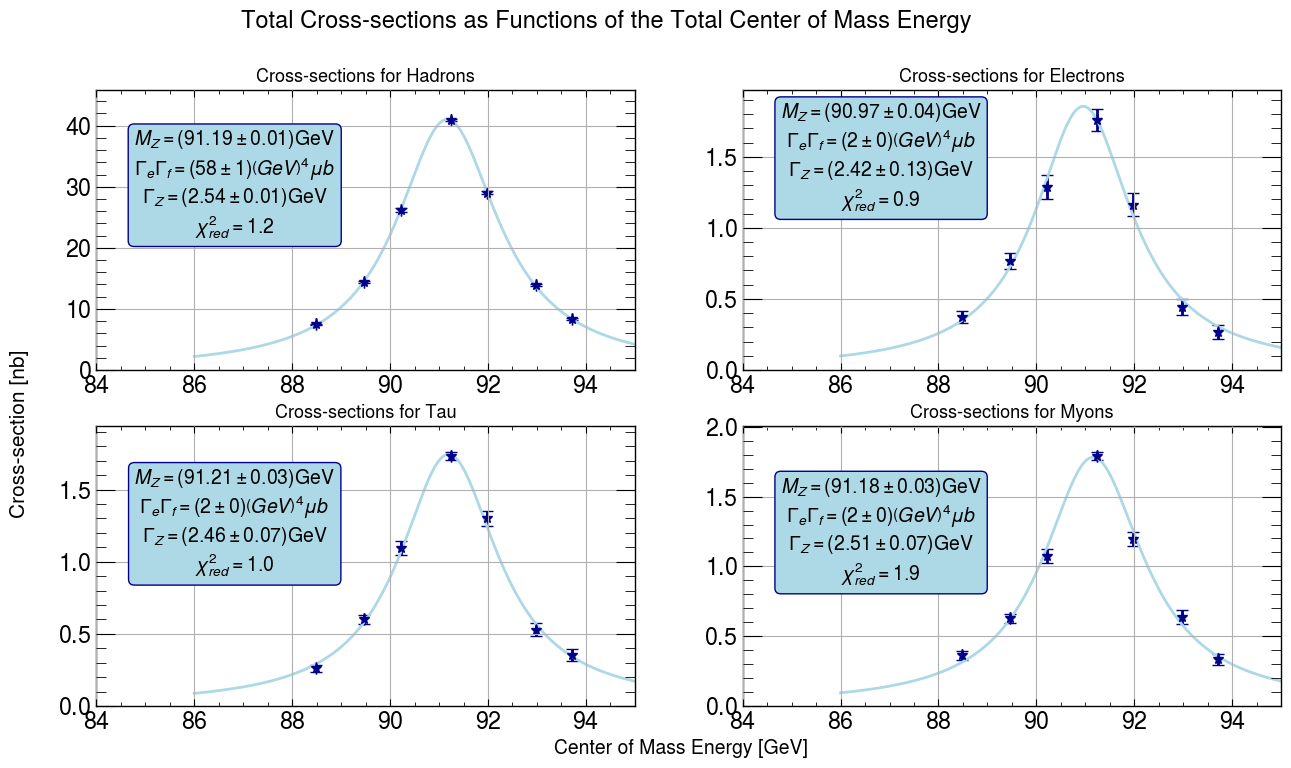

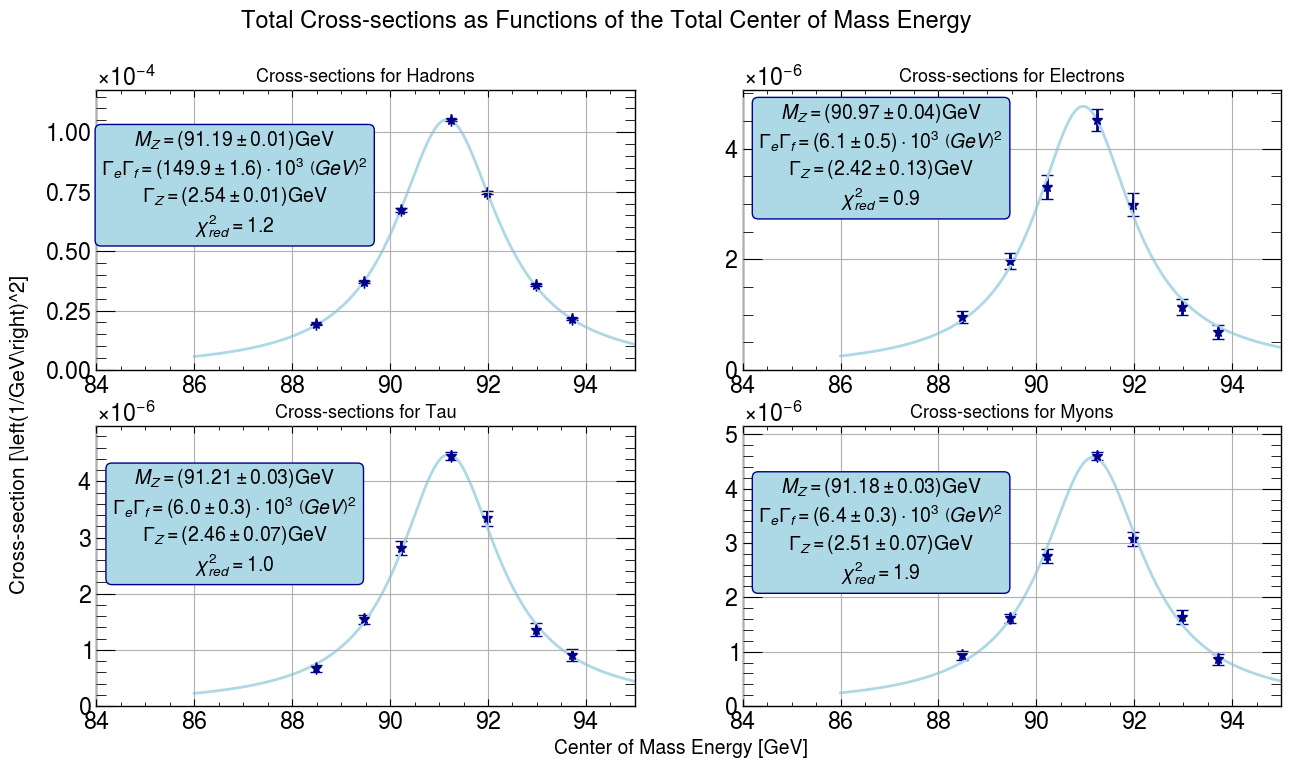

In [23]:
#Defining a factor to transform cross section's unit from nb to 1/GeV^2
factor=1/(1.973e-16)**2*1e-37

Mz=[]
dMz=[]
gamma_fe=[]
dgamma_fe=[]
gamma_z=[]
dgamma_z=[]
sigma_max=[]
dsigma_max=[]



#plotting the cross secion vs mean energy once in nb and once in 1/GeV^2
cross_sec=[cross_section1, cross_section1*factor]
dcross_sec=[dcross_section1,dcross_section1*factor ]
labels=['Cross-sections for Hadrons','Cross-sections for Electrons','Cross-sections for Tau', 'Cross-sections for Myons']
xlabel=[r'[nb]', r'[\left(1/GeV\right)^2]']
unit=[r'\left(GeV\right)^4 \mu b', r' \cdot 10^3\ \left( GeV\right)^2' ]
a= [1/1000,1e3]
b=[0,1]



for u in [0,1]:#plotting the cross secion vs mean energy once in nb and once in 1/GeV^2

    fig, ax = plt.subplots(figsize = (15, 8))

    plt.suptitle('Total Cross-sections as Functions of the Total Center of Mass Energy',y=1.03, size=17)

    fig.text(0.55, 0.1, r'Center of Mass Energy [GeV]', ha='center', fontsize=14)
    fig.text(0.1025, 0.5, r'Cross-section {}'.format(xlabel[u]), va='center', rotation='vertical', fontsize=15)

    for i in [0,1,2,3]:  #for all particle types
        plt.subplot(221+i)
        plt.title(labels[i], fontsize=13)
        plt.errorbar(mean_energy, cross_sec[u][i],dcross_sec[u][i],0, '*', color='darkblue', capsize=4,label=labels[i])
        popt1, pcov1=curve_fit(breit_wigner, mean_energy, cross_sec[u][i],sigma=dcross_sec[u][i], absolute_sigma=True, p0=[-91.18501194,252.75591492*230.92674034,2.54017013])
        #popt2, pcov2=curve_fit(breit_wigner, mean_energy, cross_section2[i])
        x=np.linspace(86, 95, 500)
        plt.xlim(84,95)
        plt.ylim(0,np.max(cross_sec[u][i])*1.12)
        plt.plot(x, breit_wigner(x, *popt1), color='lightblue')
        #plt.plot(x, breit_wigner(x, *popt2),color='pink')
        plt.grid()
        #plt.legend()

        #number of parameter: 3
        redchi=redchi2(cross_sec[u][i],breit_wigner(mean_energy,*popt1), dcross_sec[u][i],3)


        textstr = '\n'.join((
            r'$M_Z=(%.2f \pm %.2f) $GeV' % (np.abs(popt1[0]),np.sqrt(pcov1[0][0]), ),
            r'$\Gamma_e \Gamma_f=(%.{}f \pm %.{}f) {}$ '.format(b[u],b[u],unit[u]) % (popt1[1]*a[u],np.sqrt(pcov1[1][1])*a[u], ),
            r'$\Gamma_Z=(%.2f \pm %.2f) $GeV ' % (popt1[2],np.sqrt(pcov1[2][2]), ),
            r'$\chi^2_{red}=%.1f$' % (redchi, )))

        plt.text(mean_energy[0]-1.65, cross_sec[u][i][2]*1.16, textstr, size=14,ha="center",
                 va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')


        #inserting parameters into lists
        if u ==1:
            Mz.append(np.abs(popt1[0]))
            dMz.append(np.sqrt(np.abs(pcov1[0][0])))
            gamma_fe.append(np.abs(popt1[1]))
            dgamma_fe.append(np.sqrt(np.abs(pcov1[1][1])))
            gamma_z.append(np.abs(popt1[2]))
            dgamma_z.append(np.sqrt(np.abs(pcov1[2][2])))
            sigma_max.append(breit_wigner(popt1[0], *popt1))
            dsigma_max.append(12*np.pi*np.sqrt(pcov1[1][1]/(popt1[0]**2*popt1[2]**2)**2
                                +4*popt1[1]**2*pcov1[0][0]/(popt1[0]**3*popt1[2]**2)**2
                                               +4*popt1[1]**2*pcov1[2][2]/(popt1[0]**2*popt1[2]**3)**2))
            #plt.plot(x, breit_wigner(x, 91.182,0.0838**2, 2.54), 'red')

            
#the systematic error on the cross section is not used since its direction is not known
#thus we dont know if it should be added or subtracted.
#Moreover the systematic error turns out to be three magnitudes smaller than the value to be corrected and one magnitude
#smaller than the statistical error

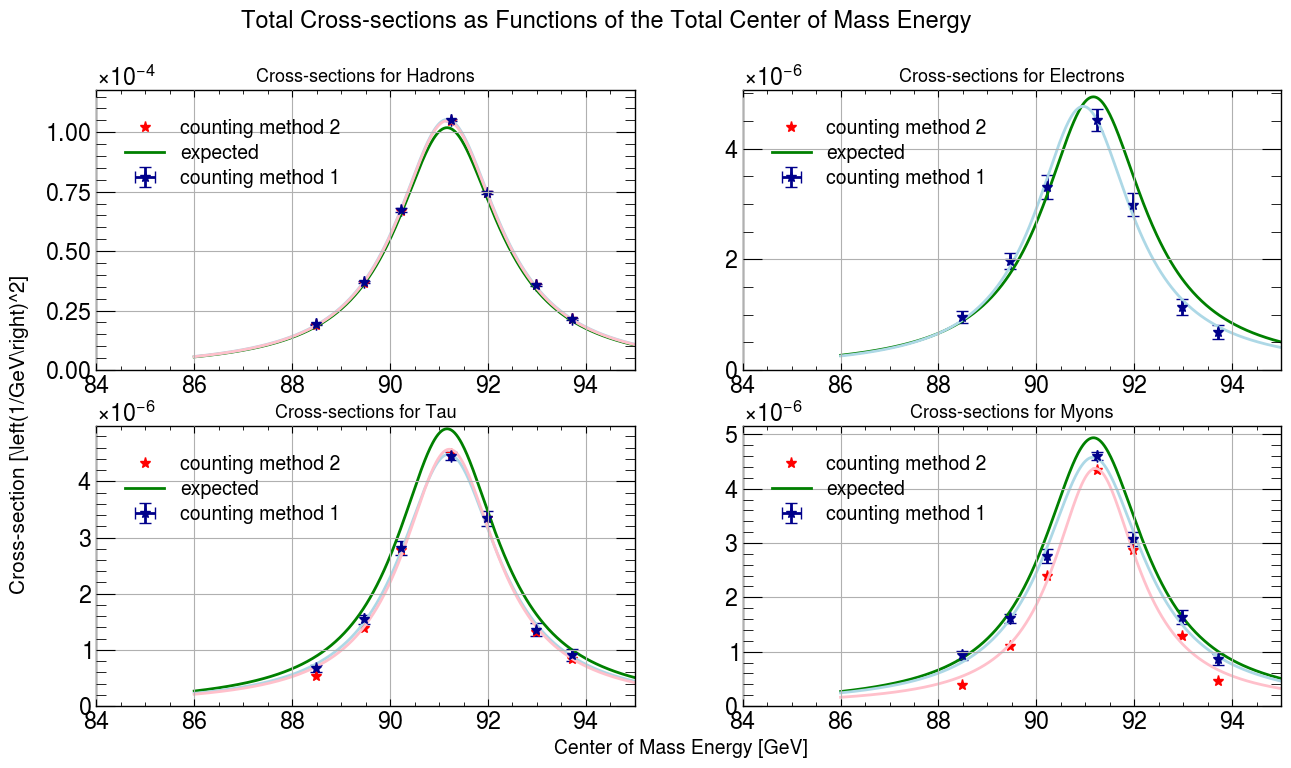

In [24]:
#Comparing both counting methods

#plotting the cross secion vs mean energy once in nb and once in 1/GeV^2
cross_sec=[cross_section1, cross_section1*factor]
dcross_sec=[dcross_section1,dcross_section1*factor ]
labels=['Cross-sections for Hadrons','Cross-sections for Electrons','Cross-sections for Tau', 'Cross-sections for Myons']
xlabel=[r'[nb]', r'[\left(1/GeV\right)^2]']
unit=[r'\left(GeV\right)^4 \mu b', r' \cdot 10^3\ \left( GeV\right)^2' ]
a= [1/1000,1e3]
b=[0,1]



for u in [1]:#plotting the cross secion vs mean energy once in nb and once in 1/GeV^2

    fig, ax = plt.subplots(figsize = (15, 8))

    plt.suptitle('Total Cross-sections as Functions of the Total Center of Mass Energy',y=1.03, size=17)

    fig.text(0.55, 0.1, r'Center of Mass Energy [GeV]', ha='center', fontsize=14)
    fig.text(0.1025, 0.5, r'Cross-section {}'.format(xlabel[u]), va='center', rotation='vertical', fontsize=15)
    a=[1.73,0.0838,0.0838,0.0838]
    for i in [0,1,2,3]:  #for all particle types
        plt.subplot(221+i)
        plt.title(labels[i], fontsize=13)
        plt.errorbar(mean_energy, cross_sec[u][i],dcross_sec[u][i],0, '*', color='darkblue', capsize=4,label='counting method 1')
        
        
        plt.plot(mean_energy, cross_section2[i]*factor,'*', color='red', label='counting method 2') #counting method 2
        popt1, pcov1=curve_fit(breit_wigner, mean_energy, cross_sec[u][i],sigma=dcross_sec[u][i], absolute_sigma=True, p0=[-91.18501194,252.75591492*230.92674034,2.54017013])
       
        popt2, pcov2=curve_fit(breit_wigner, mean_energy, cross_section2[i]*factor,p0=[-91.18501194,252.75591492*230.92674034,2.54017013])
        plt.plot(x, breit_wigner(x, 91.182,0.0838*a[i], 2.54), color= 'green', label='expected')
        x=np.linspace(86, 95, 500)
        plt.xlim(84,95)
        plt.ylim(0,np.max(cross_sec[u][i])*1.12)
        plt.plot(x, breit_wigner(x, *popt1), color='lightblue')
        plt.plot(x, breit_wigner(x, *popt2),color='pink')
        plt.grid()
        plt.legend()

#interpretation:
#there must be some systematic error on the electrons' cross section since the gauss function is shifted to the right
#such that the Z boson mass seems to be lower

In [25]:
#Displaying some results and ttest

gamma_e=np.sqrt(gamma_fe[1])
dgamma_e=dgamma_fe[1]/(2*gamma_e)
gammas=np.array([])
dgammas=np.array([])
for i in [0,1,2,3]:
    gammas=np.append(gammas, gamma_fe[i]/gamma_e)
    dgammas=np.append(dgammas, np.sqrt(dgamma_fe[i]**2/gamma_e**2+dgamma_e**2*gamma_fe[i]**2/gamma_e**4))
gammas[1]=gamma_e
dgammas[1]=dgamma_e
hadr_lit=(2*0.299+3*0.378)
lep_lit=83.8
print('partial decay width:')
print('-----------------------------------------------------')
print('hadrons:   literature value: %.2f GeV' %(hadr_lit))
print(r'measured:( %.2f  +/- %.2f) GeV, ttest:  %.1f' %(gammas[0],dgammas[0],ttest(gammas[0], dgammas[0], hadr_lit)))
print('leptons:   literature value: %.1f MeV'%(lep_lit))
print('electrons:( %.0f  +/- %.0f) MeV, ttest:  %.1f' %(gammas[1]*1000,dgammas[1]*1000,ttest(gammas[1]*1000, dgammas[1]*1000, lep_lit)))
print('taus:( %.0f  +/- %.0f) MeV, ttest:  %.1f' %(gammas[2]*1000,dgammas[2]*1000,ttest(gammas[2]*1000, dgammas[2]*1000, lep_lit)))
print('muons:( %.0f  +/- %.0f) MeV, ttest:  %.1f' %(gammas[3]*1000,dgammas[3]*1000,ttest(gammas[3]*1000, dgammas[3]*1000, lep_lit)))
print('-----------------------------------------------------')


sigma_max=np.array(sigma_max)
dsigma_max=np.array(dsigma_max)
gamma_z=np.array(gamma_z)
dgamma_z=np.array(dgamma_z)
gamma_z_weigh=np.sum(gamma_z*sigma_max)/np.sum(sigma_max)
dgamma_z_weigh=np.sqrt((np.sum(dgamma_z**2*sigma_max**2)+np.sum(gamma_z**2*dsigma_max**2))/np.sum(sigma_max)**2
                       +np.sum(gamma_z**2*sigma_max**2)*np.sum(dsigma_max**2)/np.sum(sigma_max)**4)
print('weighted total decay width: (%.1f +/- %.1f) GeV'%(gamma_z_weigh,dgamma_z_weigh))
print('total decay width obtained by hadrons: (%.2f +/- %.2f) GeV'%(gamma_z[0],dgamma_z[0]))
print('-----------------------------------------------------')

#assumption made here: 
#the Standard Model is correct and there are no other particles than the one described within this theory

gamma_nu = 167.6/1000
gamma_nu_ges=gamma_z_weigh-np.sum(gammas)
dgamma_nu_ges=np.sqrt(dgamma_z_weigh**2+np.sum(dgammas**2))
print('partial width neutrinos, %.1f MeV' %(gamma_nu*1000))
print('measured: (%.1f +/- %.1f) MeV' %(gamma_nu_ges*1000/3, dgamma_nu_ges*1000/3))
number_nu=gamma_nu_ges/gamma_nu
dnumber_nu=np.sqrt(dgamma_nu_ges**2/gamma_nu**2)
print('number of lepton generations: (%.1f +/- %.1f) '%(number_nu, dnumber_nu))

print('-------------------------------------------------------')
print('using total decay width obtained by hadrons')
gamma_nu_ges=gamma_z[0]-np.sum(gammas)
dgamma_nu_ges=np.sqrt(dgamma_z[0]**2+np.sum(dgammas**2))
print('partial decay width neutrinos, %.1f' %(gamma_nu*1000))
print('measured: (%.1f +/- %.1f) MeV' %(gamma_nu_ges*1000/3, dgamma_nu_ges*1000/3))
number_nu=gamma_nu_ges/gamma_nu
dnumber_nu=np.sqrt(dgamma_nu_ges**2/gamma_nu**2)
print('number of lepton generations: (%.1f +/- %.1f) '%(number_nu, dnumber_nu))
print('ttest lepton generations: %.1f' %(ttest(number_nu, dnumber_nu, 3))) #comparison with number of lepton generations as we know it so far
print('---------------------------------------------------------')
print('Mean of measured Z boson masses')
Mz_mean=np.mean(Mz)
dMz_mean=np.std(Mz)
dMz_mean_2=np.sum(np.array(dMz)**2)/2
print('Mz=(%.2f +/- %.2f)GeV' %(Mz_mean, dMz_mean))
print('ttest= %.1f'%(ttest(Mz_mean, dMz_mean, Mz_lit, dMz_lit)))

partial decay width:
-----------------------------------------------------
hadrons:   literature value: 1.73 GeV
measured:( 1.92  +/- 0.08) GeV, ttest:  2.5
leptons:   literature value: 83.8 MeV
electrons:( 78  +/- 3) MeV, ttest:  1.9
taus:( 77  +/- 5) MeV, ttest:  1.5
muons:( 81  +/- 5) MeV, ttest:  0.4
-----------------------------------------------------
weighted total decay width: (2.5 +/- 0.1) GeV
total decay width obtained by hadrons: (2.54 +/- 0.01) GeV
-----------------------------------------------------
partial width neutrinos, 167.6 MeV
measured: (125.2 +/- 30.9) MeV
number of lepton generations: (2.2 +/- 0.6) 
-------------------------------------------------------
using total decay width obtained by hadrons
partial decay width neutrinos, 167.6
measured: (128.2 +/- 25.7) MeV
number of lepton generations: (2.3 +/- 0.5) 
ttest lepton generations: 1.5
---------------------------------------------------------
Mean of measured Z boson masses
Mz=(91.14 +/- 0.10)GeV
ttest= 0.5


# Exercise 3: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [26]:
correction=[0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]

#literature value for sintheta^2
angle_lit=0.23122
dangle_lit=0.00004

## Simulation part

mean energy:91.248 GeV


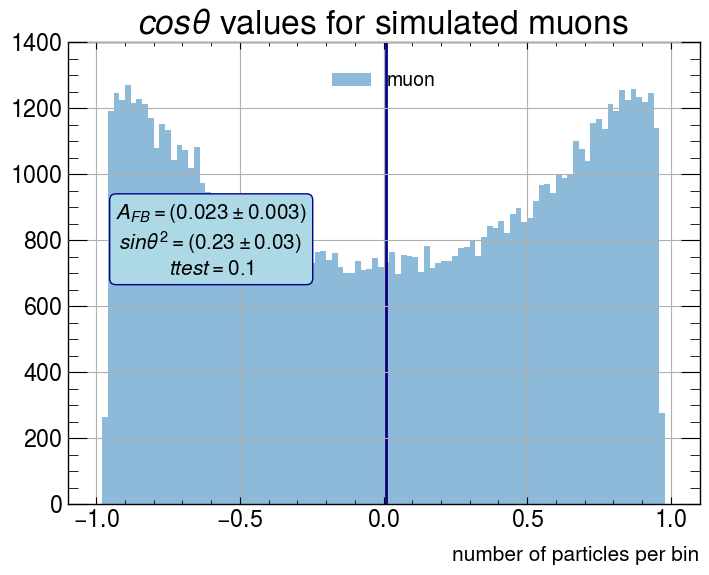

In [27]:
plt.figure()
plt.title(r'$cos \theta $ values for simulated muons')


#create histogram
entries, bin_edges, patches=plt.hist(criteria[3][4], bins=100,range=(-1,1), label='muon',alpha=0.5)
x=np.linspace(-0.99,0.99,len(entries))
    
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

          
z=50
plt.axvline(bin_middles[z], color='darkblue')

#count muons on left and right side
N_b = sum(entries[:z])
N_f=sum(entries[z:])
         
#checking the mean energy of the simulated data to know which correction to use
print('mean energy:%.3f GeV'%(criteria[3][5][0]*2))
          
          
Asym = (N_f-N_b)/(N_f+N_b) +correction[3]
d_Asym= np.sqrt(N_f/(N_f+N_b)**2+ ((N_f-N_b)/(N_f+N_b)**2)**2*N_f+N_b/(N_f+N_b)**2+ ((N_f-N_b)/(N_f+N_b)**2)**2*N_b)


sintheta2=1/4*(1-np.sqrt(Asym/3)) #approximation used since mean energy close to resonance energy

dsintheta2=1/8/np.sqrt(Asym/3)*1/3*np.sqrt(d_Asym) 

textstr = '\n'.join((
    r'$A_{FB}=(%.3f \pm %.3f) $' % (Asym, d_Asym, ),
    r'$sin\theta^2=(%.2f \pm %.2f) $ ' % (sintheta2,dsintheta2, ),
    r'$ttest=%.1f$' % (ttest(sintheta2,dsintheta2,angle_lit, dangle_lit), )))

plt.text(-0.6, 800, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')
plt.xlabel(r'angle of detection $\cos{\theta}$', fontsize=15)
plt.xlabel(r'number of particles per bin', fontsize=15)

#plt.plot(x, f(x,6,7), color='red')
    
plt.xlim(-1.1,1.1)
#plt.ylim(0,900)


plt.legend()
plt.grid()


## OPAL data

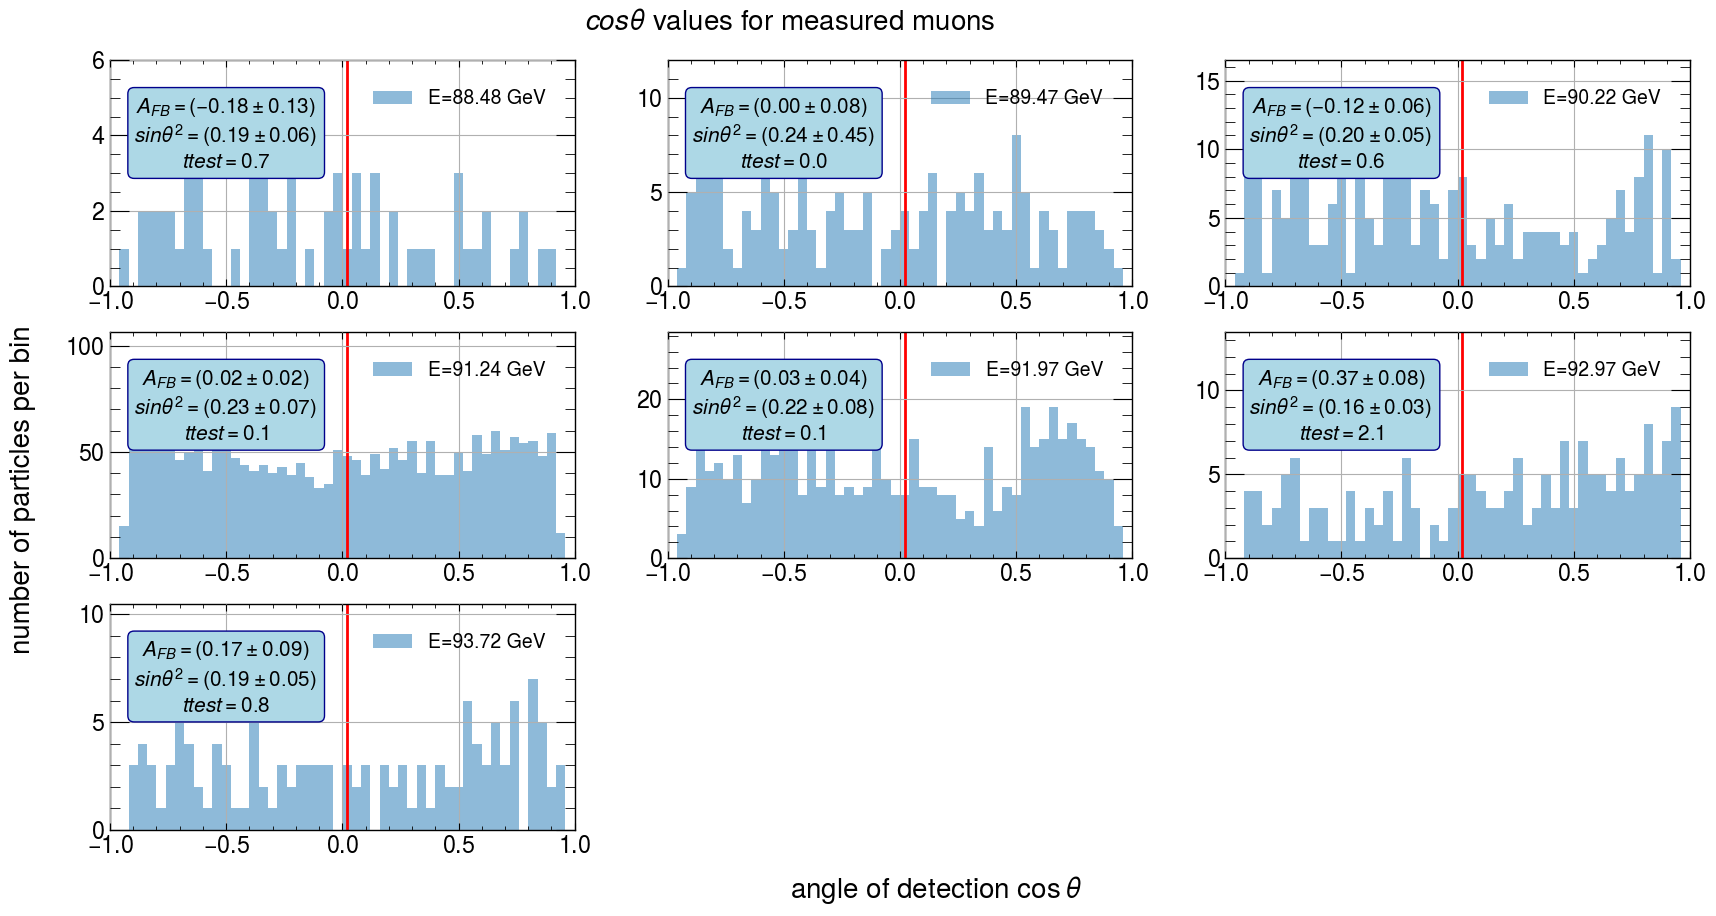

In [28]:
fig, ax = plt.subplots(figsize = (20, 10))
plt.suptitle(r'$cos \theta $ values for measured muons', fontsize=20)
fig.text(0.5, 0.1,r'angle of detection $\cos{\theta}$', va='center', rotation='horizontal', fontsize=20)
fig.text(0.11, 0.5, r'number of particles per bin', va='center', rotation='vertical', fontsize=20)
bins=50
Asym=[]
dAsym=[]
for i in range(0,7):
    plt.subplot(331+i)
    entries, bin_edges, patches=plt.hist(cos_thet_muon[i], bins=bins,range=(-1,1), label='E=%.2f GeV'%(mean_energy[i]),alpha=0.5)
    x=np.linspace(-0.99,0.99,len(entries))

    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    z=int(bins/2)   
    plt.axvline(bin_middles[z], color='red')
    N_b = sum(entries[:z])
    N_f=sum(entries[z:])
    Asymi=(N_f-N_b)/(N_f+N_b)+correction[i]
    Asym.append(Asymi)
    d_Asymi=np.sqrt(N_f/(N_f+N_b)**2+ ((N_f-N_b)/(N_f+N_b)**2)**2*N_f+N_b/(N_f+N_b)**2
                          + ((N_f-N_b)/(N_f+N_b)**2)**2*N_b)
    dAsym.append(d_Asymi)

    
    sintheta2=1/4*(1-np.sqrt(np.abs(Asymi)/3))

    dsintheta2=1/8/np.sqrt(np.abs(Asymi)/3)*1/3*np.sqrt(d_Asymi)  

    textstr = '\n'.join((
        r'$A_{FB}=(%.2f \pm %.2f) $' % (Asymi, d_Asymi, ),
        r'$sin\theta^2=(%.2f \pm %.2f) $ ' % (sintheta2,dsintheta2, ), #approximation only reasonable at resonace energy
        r'$ttest=%.1f$' % (ttest(sintheta2,dsintheta2,angle_lit, dangle_lit), )))

    plt.text(-0.5, max(entries)*1.01, textstr, size=15,ha="center",
             va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')


    plt.xlim(-1,1)
    
    
    plt.ylim(0,max(entries)*1.5)
    plt.legend(loc='upper right')
    plt.grid()



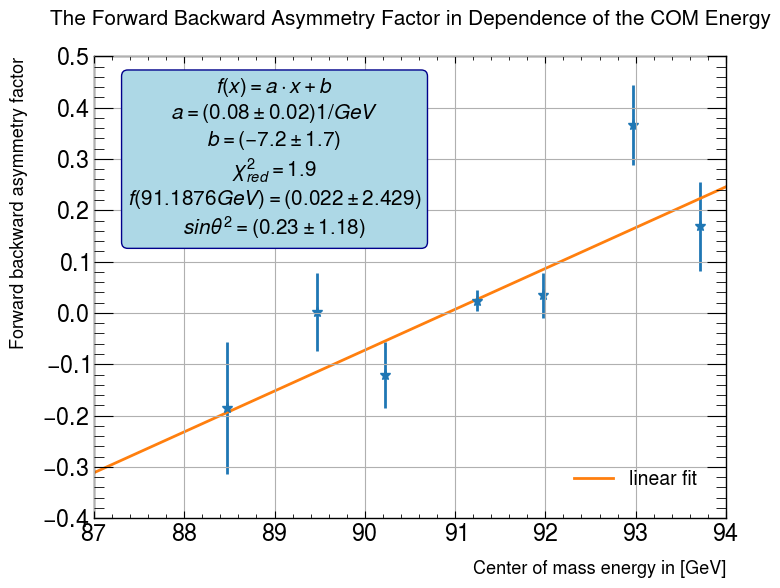

In [29]:
#Plot asym_corr vs. mean energy
#and linear fit

#in order to use the following approximation the Asymmetry factor has to be measured exactly at the resonance energy 
#therefore the asymmetry factors of all energies are plotted and fitted with a linear function
#by doing this the asymmetry factor at the resonance energy can be calculated


plt.title('The Forward Backward Asymmetry Factor in Dependence of the COM Energy', fontsize=15, y=1.05)
Asym_corr=(np.array(Asym))
plt.xlabel('Center of mass energy in [GeV]', fontsize=13)
plt.ylabel('Forward backward asymmetry factor', fontsize=13)
plt.errorbar(mean_energy, Asym_corr,dAsym,0,'*')

popt_lin, pcov_lin=curve_fit(lin, mean_energy,Asym_corr, sigma=dAsym, absolute_sigma=True)

x=np.linspace(87, 94, 500)
plt.plot(x, lin(x, *popt_lin), label='linear fit')

redchi_lin=redchi2(Asym_corr, lin(mean_energy, *popt_lin), dAsym)

Asym_lin=lin(Mz_lit,*popt_lin)
dAsym_lin =np.sqrt(pcov_lin[0][0]*Mz_lit**2+popt[0]**2*dMz_lit**2+pcov_lin[1][1])

sintheta2_lin=1/4*(1-np.sqrt(Asym_lin/3))

dsintheta2_lin=1/8/np.sqrt(Asym_lin/3)*1/3*dAsym_lin


textstr = '\n'.join((
    r'$f(x)=a \cdot x+b$',
r'$a=(%.2f \pm %.2f) 1/GeV$' % (popt_lin[0],np.sqrt(pcov_lin[0][0]), ),
    r'$b=(%.1f \pm %.1f) $ ' % (popt_lin[1],np.sqrt(pcov_lin[1][1]), ),
    r'$\chi^2_{red}=%.1f$' % (redchi, ),
    '$f(91.1876GeV)=(%.3f \pm %.3f)$' %(Asym_lin,dAsym_lin),
    r'$sin \theta^2 = (%.2f \pm %.2f)$' %(sintheta2_lin, dsintheta2_lin)))
plt.text(89, 0.3, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')

plt.grid()
plt.legend(loc='lower right')

In [30]:
print('Weinberg angle literature value')
print('----------------------------')
print('sintheta^2= 0.23122(4)')
print('----------------------------')
print('Forward-backward asymmetry and Weinberg angle obtained from linear fit:')
print('------------------------------------------------')
print('A_FB=(%.2f +/- %.2f)' %(Asym_lin, dAsym_lin)) 
print('sintheta^2= (%.2f +/- %.2f),   ttest: %.1f' %(sintheta2_lin,dsintheta2_lin,ttest(sintheta2_lin,dsintheta2_lin,angle_lit, dangle_lit)))
print('------------------------------------------')
#since the error is very large due to the errors of the fit
#we calculate the asymmetry additionally in the following way:


sintheta2_res=1/4*(1-np.sqrt(Asym_corr[3]/3))

dsintheta2_res=1/8/np.sqrt(Asym_corr[3]/3)*1/3*np.sqrt(dAsym[3])
print('Forward-backward asymmetry and Weinberg angle obtained at given energy close to resonance:')
print('------------------------------------------------')
print('A_FB=(%.2f +/- %.2f)'%(Asym_corr[3], dAsym[3])) 
print('sintheta^2= (%.2f +/- %.2f),   ttest: %.1f' %(sintheta2_res,dsintheta2_res,ttest(sintheta2_res,dsintheta2_res,angle_lit, dangle_lit)))


Weinberg angle literature value
----------------------------
sintheta^2= 0.23122(4)
----------------------------
Forward-backward asymmetry and Weinberg angle obtained from linear fit:
------------------------------------------------
A_FB=(0.02 +/- 2.43)
sintheta^2= (0.23 +/- 1.18),   ttest: 0.0
------------------------------------------
Forward-backward asymmetry and Weinberg angle obtained at given energy close to resonance:
------------------------------------------------
A_FB=(0.02 +/- 0.02)
sintheta^2= (0.23 +/- 0.07),   ttest: 0.1


# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.

In [31]:

ratio_sigma=sigma_max/sigma_max[0]
dratio_sigma=np.sqrt((dsigma_max/sigma_max[0])**2+(sigma_max/sigma_max[0]**2*dsigma_max[0])**2)
print('ratio of the hadrons and leptons cross sections:')
print('-------------------------------------------------------')
print('e/h: (%.0f +/- %.0f) %%'%(ratio_sigma[1]*100, dratio_sigma[1]*100))
print('tau/h: (%.1f +/- %.1f) %%'%(ratio_sigma[2]*100, dratio_sigma[2]*100))
print('muon/h: (%.1f +/- %.1f)%%'%(ratio_sigma[3]*100, dratio_sigma[3]*100))
#ratio_branch= np.mean([gammas[1],gammas[2],gammas[3]])/gammas[0]
ratio_branch=gammas/gamma_z_weigh
dratio_branch=np.sqrt((dgammas/gamma_z_weigh)**2+(dgamma_z*np.array(gammas)/gamma_z_weigh**2)**2)
ratio_ratio=ratio_branch/ratio_branch[0]
dratio_ratio=np.sqrt((dratio_branch/ratio_branch[0])**2+(dratio_branch[0]*ratio_branch/ratio_branch[0]**2)**2)
print('-------------------------------------------------------')
print('branching ratios:')
print('-------------------------------------------------------')
print('hadrons: (%.1f +/- %.1f) %%'%(ratio_branch[0]*100, dratio_branch[0]*100))
print('electrons: (%.1f +/- %.1f) %%'%(ratio_branch[1]*100, dratio_branch[1]*100))
print('taus: (%.1f +/- %.1f) %%'%(ratio_branch[2]*100, dratio_branch[2]*100))
print('muons: (%.1f +/- %.1f)%%'%(ratio_branch[3]*100, dratio_branch[3]*100))
print('-------------------------------------------------------')
print('ratios of branching ratios in comparison to ratios of cross sections:')
print('-------------------------------------------------------')
print('e/h: (%.1f +/- %.1f) %%'%(ratio_ratio[1]*100, dratio_ratio[1]*100),',     ttest: %.1f'% (ttest(ratio_ratio[1], dratio_ratio[1],ratio_sigma[1], dratio_sigma[1]) ))
print('tau/h: (%.1f +/- %.1f) %%'%(ratio_ratio[2]*100, dratio_ratio[2]*100),',     ttest: %.1f'% (ttest(ratio_ratio[2], dratio_ratio[2],ratio_sigma[2], dratio_sigma[2]) ))
print('muon/h: (%.1f +/- %.1f)%%'%(ratio_ratio[3]*100, dratio_ratio[3]*100),',     ttest: %.1f'% (ttest(ratio_ratio[3], dratio_ratio[3],ratio_sigma[3], dratio_sigma[3]) ))
print('-------------------------------------------------------')


ratio of the hadrons and leptons cross sections:
-------------------------------------------------------
e/h: (5 +/- 1) %
tau/h: (4.3 +/- 0.3) %
muon/h: (4.3 +/- 0.3)%
-------------------------------------------------------
branching ratios:
-------------------------------------------------------
hadrons: (75.8 +/- 3.0) %
electrons: (3.1 +/- 0.2) %
taus: (3.0 +/- 0.2) %
muons: (3.2 +/- 0.2)%
-------------------------------------------------------
ratios of branching ratios in comparison to ratios of cross sections:
-------------------------------------------------------
e/h: (4.1 +/- 0.3) % ,     ttest: 0.7
tau/h: (4.0 +/- 0.3) % ,     ttest: 0.6
muon/h: (4.2 +/- 0.3)% ,     ttest: 0.2
-------------------------------------------------------
